In [1]:
# =============================================================================
# CELL 1: Environment Setup & Path Configuration
# =============================================================================

import os
import sys
from pathlib import Path

# Detect environment
IN_COLAB = 'google.colab' in sys.modules
IN_KAGGLE = 'KAGGLE_KERNEL_RUN_TYPE' in os.environ

if IN_COLAB:
    # Clone repo if in Colab
    REPO_URL = 'https://github.com/aayushakumar/ood-eval-toxic-classifiers.git'
    REPO_DIR = '/content/ood-eval-toxic-classifiers'

    if not os.path.exists(REPO_DIR):
        print(f"Cloning repository...")
        !git clone {REPO_URL} {REPO_DIR}

    os.chdir(REPO_DIR)
    ROOT_DIR = Path(REPO_DIR)

    # Install requirements
    !pip install -q transformers datasets scikit-learn tqdm

elif IN_KAGGLE:
    ROOT_DIR = Path('/kaggle/working')
else:
    # Local / VS Code
    ROOT_DIR = Path('.').resolve().parent
    if not (ROOT_DIR / 'scripts').exists():
        ROOT_DIR = Path('.').resolve()

# Add scripts to path
SCRIPTS_DIR = ROOT_DIR / 'scripts'
if str(SCRIPTS_DIR) not in sys.path:
    sys.path.insert(0, str(SCRIPTS_DIR))
if str(ROOT_DIR) not in sys.path:
    sys.path.insert(0, str(ROOT_DIR))

DATA_DIR = ROOT_DIR / 'data'
OUTPUT_DIR = ROOT_DIR / 'output'
RESULTS_DIR = OUTPUT_DIR / 'results'
FIGURES_DIR = OUTPUT_DIR / 'figures'
MODELS_DIR = OUTPUT_DIR / 'models'

for d in [OUTPUT_DIR, RESULTS_DIR, FIGURES_DIR, MODELS_DIR]:
    d.mkdir(parents=True, exist_ok=True)

print(f"Root: {ROOT_DIR}")
print(f"Data: {DATA_DIR}")
print(f"Scripts: {SCRIPTS_DIR}")

Cloning repository...
Cloning into '/content/ood-eval-toxic-classifiers'...
remote: Enumerating objects: 203, done.
remote: Counting objects: 100% (203/203), done.
remote: Compressing objects: 100% (152/152), done.
remote: Total 203 (delta 70), reused 160 (delta 46), pack-reused 0 (from 0)
Receiving objects: 100% (203/203), 8.61 MiB | 12.50 MiB/s, done.
Resolving deltas: 100% (70/70), done.
Filtering content: 100% (19/19), 2.17 GiB | 52.13 MiB/s, done.
Root: /content/ood-eval-toxic-classifiers
Data: /content/ood-eval-toxic-classifiers/data
Scripts: /content/ood-eval-toxic-classifiers/scripts


In [2]:
# =============================================================================
# CELL 2: Import from Project Scripts
# =============================================================================

# Standard imports
import warnings
warnings.filterwarnings('ignore')

import numpy as np
import pandas as pd
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm.auto import tqdm
from sklearn.metrics import (
    accuracy_score, f1_score, precision_score, recall_score,
    roc_auc_score, average_precision_score, roc_curve, precision_recall_curve,
    log_loss, brier_score_loss
)
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.svm import LinearSVC
import json
import pickle
from datetime import datetime
from collections import defaultdict

# Import from our scripts
from run_roberta import (
    set_seed, load_dataset, SUPPORTED_DATASETS,
    ToxicityDataset, build_model, train_one_epoch, evaluate,
    expected_calibration_error, fit_temperature, fit_isotonic
)
from run_tfidf_baselines import (
    evaluate_sklearn_classifier, train_and_evaluate_tfidf
)
from ood_algorithms import (
    MaxSoftmaxOOD, ODIN_OOD, EnergyOOD, MahalanobisOOD,
    CORAL, MMD,
    TemperatureScaling, IsotonicCalibration, PlattScaling
)
from fairness_metrics import compute_group_fairness

print("✓ Imported from project scripts")

✓ Imported from project scripts


In [3]:
# =============================================================================
# CELL 3: Configuration
# =============================================================================

# Device setup
DEVICE = 'cuda' if torch.cuda.is_available() else 'cpu'
if torch.cuda.is_available():
    GPU_NAME = torch.cuda.get_device_name(0)
    GPU_MEM = torch.cuda.get_device_properties(0).total_memory / 1e9
    print(f"GPU: {GPU_NAME} ({GPU_MEM:.1f} GB)")
else:
    print("Running on CPU")

# Experiment config
CONFIG = {
    'seed': 42,
    'datasets': ['jigsaw', 'civil', 'hatexplain'],

    # RoBERTa training
    'model_name': 'roberta-base',
    'max_length': 128,
    'batch_size': 64 if 'A100' in globals().get('GPU_NAME', '') else 32,
    'epochs': 5,
    'learning_rate': 2e-5,
    'warmup_ratio': 0.1,

    # TF-IDF
    'tfidf_max_features': 50000,
    'tfidf_ngram_range': (1, 2),

    # Paths
    'data_dir': str(DATA_DIR),
    'save_models': True,
}

set_seed(CONFIG['seed'])
print(f"\nConfig: {json.dumps(CONFIG, indent=2, default=str)}")

GPU: NVIDIA A100-SXM4-80GB (85.2 GB)

Config: {
  "seed": 42,
  "datasets": [
    "jigsaw",
    "civil",
    "hatexplain"
  ],
  "model_name": "roberta-base",
  "max_length": 128,
  "batch_size": 64,
  "epochs": 5,
  "learning_rate": 2e-05,
  "warmup_ratio": 0.1,
  "tfidf_max_features": 50000,
  "tfidf_ngram_range": [
    1,
    2
  ],
  "data_dir": "/content/ood-eval-toxic-classifiers/data",
  "save_models": true
}


In [4]:
# =============================================================================
# CELL 4: Load All Datasets
# =============================================================================

data = {}

for name in CONFIG['datasets']:
    print(f"\nLoading {name}...")
    data[name] = {}

    for split in ['train', 'val', 'test']:
        try:
            df = load_dataset(name, split, CONFIG['data_dir'])
            data[name][split] = df
            pos_rate = df['label'].mean()
            print(f"  {split}: {len(df):,} samples, {pos_rate:.1%} positive")
        except FileNotFoundError as e:
            print(f"  {split}: Not found")

print("\n✓ Data loaded")


Loading jigsaw...
  train: 1,420,932 samples, 8.0% positive
  val: 177,616 samples, 8.0% positive
  test: 89,780 samples, 8.0% positive

Loading civil...
  train: 1,776,165 samples, 8.0% positive
  val: 96,717 samples, 7.9% positive
  test: 96,702 samples, 8.0% positive

Loading hatexplain...
  train: 16,087 samples, 59.6% positive
  val: 2,011 samples, 59.6% positive
  test: 2,011 samples, 59.6% positive

✓ Data loaded


In [5]:
# =============================================================================
# CELL 5: Results Tracker (Lightweight)
# =============================================================================

class Results:
    """Simple results storage."""
    def __init__(self):
        self.classification = []
        self.ood = []
        self.calibration = []
        self.fairness = []
        self.predictions = {}

    def add(self, category, **kwargs):
        getattr(self, category).append(kwargs)

    def get_df(self, category):
        return pd.DataFrame(getattr(self, category))

    def save(self, path):
        data = {
            'classification': self.classification,
            'ood': self.ood,
            'calibration': self.calibration,
            'fairness': self.fairness,
        }
        with open(path, 'w') as f:
            json.dump(data, f, indent=2, default=float)

results = Results()
print("✓ Results tracker initialized")

✓ Results tracker initialized


---
## Section 1: TF-IDF Baseline Experiments

Using `train_and_evaluate_tfidf` from `scripts/run_tfidf_baselines.py`

In [6]:
# =============================================================================
# CELL 6: TF-IDF Baselines - Train & Cross-Domain Eval
# =============================================================================

print("="*60)
print("TF-IDF BASELINE EXPERIMENTS")
print("="*60)

tfidf_results = {}

for source in CONFIG['datasets']:
    if source not in data or 'train' not in data[source]:
        continue

    print(f"\n{'='*40}\nTraining on {source.upper()}\n{'='*40}")

    # Use existing function from run_tfidf_baselines.py
    for model_type in ['logreg', 'svm']:
        print(f"\n  TF-IDF + {model_type.upper()}:")

        # Vectorize
        vectorizer = TfidfVectorizer(
            max_features=CONFIG['tfidf_max_features'],
            ngram_range=CONFIG['tfidf_ngram_range'],
            min_df=5, sublinear_tf=True
        )
        X_train = vectorizer.fit_transform(data[source]['train']['text'].fillna(''))
        y_train = data[source]['train']['label'].values

        # Train
        if model_type == 'logreg':
            model = LogisticRegression(max_iter=1000, class_weight='balanced', n_jobs=-1)
        else:
            model = LinearSVC(max_iter=5000, dual=False, class_weight='balanced')
        model.fit(X_train, y_train)

        # Evaluate on all test sets
        for target in CONFIG['datasets']:
            if target not in data or 'test' not in data[target]:
                continue

            X_test = vectorizer.transform(data[target]['test']['text'].fillna(''))
            y_test = data[target]['test']['label'].values

            # Use existing evaluation function
            metrics = evaluate_sklearn_classifier(X_test, y_test, model, model_type)

            # Store
            eval_type = 'in-domain' if source == target else 'cross-domain'
            results.add('classification',
                model=f'TF-IDF-{model_type.upper()}', source=source, target=target,
                eval_type=eval_type, **metrics
            )

            marker = "★" if source == target else "→"
            print(f"    {marker} {target}: F1={metrics['f1']:.4f}, AUROC={metrics.get('auroc', 0):.4f}")

        # Save model
        if CONFIG['save_models']:
            key = f"tfidf_{model_type}_{source}"
            tfidf_results[key] = {'vectorizer': vectorizer, 'model': model}

print("\n✓ TF-IDF experiments complete")

TF-IDF BASELINE EXPERIMENTS

Training on JIGSAW

  TF-IDF + LOGREG:
    ★ jigsaw: F1=0.5678, AUROC=0.9425
    → civil: F1=0.5684, AUROC=0.9422
    → hatexplain: F1=0.6335, AUROC=0.5654

  TF-IDF + SVM:
    ★ jigsaw: F1=0.5512, AUROC=0.9306
    → civil: F1=0.5545, AUROC=0.9302
    → hatexplain: F1=0.6224, AUROC=0.5647

Training on CIVIL

  TF-IDF + LOGREG:
    → jigsaw: F1=0.5934, AUROC=0.9601
    ★ civil: F1=0.5685, AUROC=0.9439
    → hatexplain: F1=0.6402, AUROC=0.5645

  TF-IDF + SVM:
    → jigsaw: F1=0.6100, AUROC=0.9662
    ★ civil: F1=0.5574, AUROC=0.9343
    → hatexplain: F1=0.6254, AUROC=0.5664

Training on HATEXPLAIN

  TF-IDF + LOGREG:
    → jigsaw: F1=0.1743, AUROC=0.6099
    → civil: F1=0.1806, AUROC=0.6226
    ★ hatexplain: F1=0.7873, AUROC=0.8375

  TF-IDF + SVM:
    → jigsaw: F1=0.1717, AUROC=0.5905
    → civil: F1=0.1783, AUROC=0.6036
    ★ hatexplain: F1=0.7713, AUROC=0.8170

✓ TF-IDF experiments complete


---
## Section 2: RoBERTa Training & Cross-Domain Evaluation

Using `ToxicityDataset`, `build_model`, `train_one_epoch`, `evaluate` from `scripts/run_roberta.py`

In [9]:
# =============================================================================
# CELL 7: RoBERTa Training
# =============================================================================

from transformers import AutoTokenizer, get_linear_schedule_with_warmup
from torch.optim import AdamW
from torch.cuda.amp import GradScaler, autocast

print("RoBERTa TRAINING & CROSS-DOMAIN EVALUATION")
print("="*60)

# === SPEED SETTINGS (modify here) ===
MAX_TRAIN_SAMPLES = 100000  # Limit training data for speed
MAX_VAL_SAMPLES = 10000
USE_FP16 = True  # Mixed precision for 2x speedup
# ====================================

roberta_models = {}
training_histories = {}
eval_results = {}

tokenizer = AutoTokenizer.from_pretrained(CONFIG['model_name'])
scaler = GradScaler() if USE_FP16 else None

for source in CONFIG['datasets']:
    if source not in data or 'train' not in data[source]:
        continue

    print(f"\n{'='*50}\nTraining RoBERTa on {source.upper()}\n{'='*50}")

    # Sample data for speed
    train_df = data[source]['train']
    val_df = data[source]['val']

    if len(train_df) > MAX_TRAIN_SAMPLES:
        train_df = train_df.sample(n=MAX_TRAIN_SAMPLES, random_state=42)
        print(f"  Sampled train: {len(train_df):,} / {len(data[source]['train']):,}")
    if len(val_df) > MAX_VAL_SAMPLES:
        val_df = val_df.sample(n=MAX_VAL_SAMPLES, random_state=42)

    print(f"  Creating datasets...")
    train_dataset = ToxicityDataset(train_df, tokenizer, max_len=CONFIG['max_length'])
    val_dataset = ToxicityDataset(val_df, tokenizer, max_len=CONFIG['max_length'])

    train_loader = DataLoader(train_dataset, batch_size=CONFIG['batch_size'], shuffle=True, num_workers=2, pin_memory=True)
    val_loader = DataLoader(val_dataset, batch_size=CONFIG['batch_size'], shuffle=False, num_workers=2, pin_memory=True)
    print(f"  ✓ {len(train_loader):,} train batches, {len(val_loader):,} val batches")

    model = build_model(CONFIG['model_name'], num_labels=2, device=DEVICE)
    print(f"  ✓ Model on {DEVICE}")

    optimizer = AdamW(model.parameters(), lr=CONFIG['learning_rate'], weight_decay=0.01)
    total_steps = len(train_loader) * CONFIG['epochs']
    scheduler = get_linear_schedule_with_warmup(
        optimizer, num_warmup_steps=int(total_steps * CONFIG['warmup_ratio']),
        num_training_steps=total_steps
    )

    history = {'train_loss': [], 'val_loss': [], 'val_f1': []}
    best_f1, best_state = 0, None

    for epoch in range(CONFIG['epochs']):
        # === Training with progress bar ===
        model.train()
        total_loss = 0
        pbar = tqdm(train_loader, desc=f"Epoch {epoch+1}/{CONFIG['epochs']}", leave=True)

        for batch in pbar:
            optimizer.zero_grad()
            input_ids = batch['input_ids'].to(DEVICE)
            attention_mask = batch['attention_mask'].to(DEVICE)
            labels = batch['labels'].to(DEVICE)

            if USE_FP16:
                with autocast():
                    outputs = model(input_ids=input_ids, attention_mask=attention_mask, labels=labels)
                    loss = outputs.loss
                scaler.scale(loss).backward()
                scaler.step(optimizer)
                scaler.update()
            else:
                outputs = model(input_ids=input_ids, attention_mask=attention_mask, labels=labels)
                loss = outputs.loss
                loss.backward()
                optimizer.step()

            scheduler.step()
            total_loss += loss.item()
            pbar.set_postfix({'loss': f'{loss.item():.4f}'})

        train_loss = total_loss / len(train_loader)
        history['train_loss'].append(train_loss)

        # === Validation ===
        val_metrics = evaluate(model, val_loader, DEVICE, return_probs=True)
        history['val_loss'].append(val_metrics.get('nll', 0))
        history['val_f1'].append(val_metrics['f1'])

        print(f"  Epoch {epoch+1}: Loss={train_loss:.4f}, Val F1={val_metrics['f1']:.4f}")

        if val_metrics['f1'] > best_f1:
            best_f1 = val_metrics['f1']
            best_state = {k: v.cpu().clone() for k, v in model.state_dict().items()}

    if best_state:
        model.load_state_dict({k: v.to(DEVICE) for k, v in best_state.items()})

    roberta_models[source] = model
    training_histories[source] = history
    print(f"  ✓ Best Val F1: {best_f1:.4f}")

    # Cross-domain evaluation
    print(f"\n  Cross-domain evaluation:")
    for target in CONFIG['datasets']:
        if target not in data or 'test' not in data[target]:
            continue

        test_df = data[target]['test']
        test_dataset = ToxicityDataset(test_df, tokenizer, max_len=CONFIG['max_length'])
        test_loader = DataLoader(test_dataset, batch_size=CONFIG['batch_size'], shuffle=False, num_workers=2)

        metrics = evaluate(model, test_loader, DEVICE, return_probs=True)

        eval_key = f"{source}_to_{target}"
        eval_results[eval_key] = {
            'logits': metrics.get('logits'),
            'labels': metrics.get('labels'),
            'probs': metrics.get('pos_probs'),
        }

        eval_type = 'in-domain' if source == target else 'cross-domain'
        results.add('classification',
            model='RoBERTa', source=source, target=target,
            eval_type=eval_type,
            accuracy=metrics['accuracy'], f1=metrics['f1'],
            auroc=metrics.get('auroc', 0), ece=metrics.get('ece', 0)
        )

        marker = "★" if source == target else "→"
        print(f"    {marker} {target}: F1={metrics['f1']:.4f}, AUROC={metrics.get('auroc', 0):.4f}")

    if CONFIG['save_models']:
        torch.save(model.state_dict(), MODELS_DIR / f'roberta_{source}.pt')

    if torch.cuda.is_available():
        torch.cuda.empty_cache()

print("\n✓ RoBERTa training complete")

RoBERTa TRAINING & CROSS-DOMAIN EVALUATION

Training RoBERTa on JIGSAW
  Sampled train: 100,000 / 1,420,932
  Creating datasets...
  ✓ 1,563 train batches, 157 val batches


Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at roberta-base and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


  ✓ Model on cuda


Epoch 1/5:   0%|          | 0/1563 [00:00<?, ?it/s]

  Epoch 1: Loss=0.1915, Val F1=0.5866


Epoch 2/5:   0%|          | 0/1563 [00:00<?, ?it/s]

  Epoch 2: Loss=0.1224, Val F1=0.6584


Epoch 3/5:   0%|          | 0/1563 [00:00<?, ?it/s]

  Epoch 3: Loss=0.0950, Val F1=0.6583


Epoch 4/5:   0%|          | 0/1563 [00:00<?, ?it/s]

  Epoch 4: Loss=0.0682, Val F1=0.6509


Epoch 5/5:   0%|          | 0/1563 [00:00<?, ?it/s]

  Epoch 5: Loss=0.0462, Val F1=0.6543
  ✓ Best Val F1: 0.6584

  Cross-domain evaluation:
    ★ jigsaw: F1=0.6655, AUROC=0.9564
    → civil: F1=0.6678, AUROC=0.9566
    → hatexplain: F1=0.7215, AUROC=0.6867

Training RoBERTa on CIVIL
  Sampled train: 100,000 / 1,776,165
  Creating datasets...
  ✓ 1,563 train batches, 157 val batches


Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at roberta-base and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


  ✓ Model on cuda


Epoch 1/5:   0%|          | 0/1563 [00:00<?, ?it/s]

  Epoch 1: Loss=0.1879, Val F1=0.6265


Epoch 2/5:   0%|          | 0/1563 [00:00<?, ?it/s]

  Epoch 2: Loss=0.1205, Val F1=0.6640


Epoch 3/5:   0%|          | 0/1563 [00:00<?, ?it/s]

  Epoch 3: Loss=0.0914, Val F1=0.6824


Epoch 4/5:   0%|          | 0/1563 [00:00<?, ?it/s]

  Epoch 4: Loss=0.0640, Val F1=0.6623


Epoch 5/5:   0%|          | 0/1563 [00:00<?, ?it/s]

  Epoch 5: Loss=0.0410, Val F1=0.6568
  ✓ Best Val F1: 0.6824

  Cross-domain evaluation:
    → jigsaw: F1=0.6758, AUROC=0.9565
    ★ civil: F1=0.6718, AUROC=0.9555
    → hatexplain: F1=0.6882, AUROC=0.6714

Training RoBERTa on HATEXPLAIN
  Creating datasets...
  ✓ 252 train batches, 32 val batches


Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at roberta-base and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


  ✓ Model on cuda


Epoch 1/5:   0%|          | 0/252 [00:00<?, ?it/s]

  Epoch 1: Loss=0.5711, Val F1=0.8108


Epoch 2/5:   0%|          | 0/252 [00:00<?, ?it/s]

  Epoch 2: Loss=0.4486, Val F1=0.8155


Epoch 3/5:   0%|          | 0/252 [00:00<?, ?it/s]

  Epoch 3: Loss=0.3819, Val F1=0.8288


Epoch 4/5:   0%|          | 0/252 [00:00<?, ?it/s]

Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7a8e12d4e2a0>
Traceback (most recent call last):
  File "/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py", line 1654, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py", line 1637, in _shutdown_workers
    if w.is_alive():
       ^^^^^^^^^^^^
  File "/usr/lib/python3.12/multiprocessing/process.py", line 160, in is_alive
    assert self._parent_pid == os.getpid(), 'can only test a child process'
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
AssertionError: can only test a child process
Exception ignored in: <function _MultiProcessingDataLoaderIter.__del__ at 0x7a8e12d4e2a0>
Traceback (most recent call last):
  File "/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py", line 1654, in __del__
    self._shutdown_workers()
  File "/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py", line 16

  Epoch 4: Loss=0.3136, Val F1=0.8079


Epoch 5/5:   0%|          | 0/252 [00:00<?, ?it/s]

  Epoch 5: Loss=0.2562, Val F1=0.8228
  ✓ Best Val F1: 0.8288

  Cross-domain evaluation:
    → jigsaw: F1=0.3193, AUROC=0.7637
    → civil: F1=0.3257, AUROC=0.7701
    ★ hatexplain: F1=0.8383, AUROC=0.8814

✓ RoBERTa training complete


---
## Section 3: OOD Detection & Calibration

Using classes from `scripts/ood_algorithms.py`:
- OOD: `MaxSoftmaxOOD`, `ODIN_OOD`, `EnergyOOD`, `MahalanobisOOD`
- Domain Shift: `CORAL`, `MMD`
- Calibration: `TemperatureScaling`, `IsotonicCalibration`, `PlattScaling`

In [ ]:
# =============================================================================
# CELL 8: OOD Detection (Using Imported Classes)
# =============================================================================

print("OOD DETECTION")
print("="*60)

# Initialize OOD detectors from ood_algorithms.py
ood_detectors = {
    'MaxSoftmax': MaxSoftmaxOOD(),
    'ODIN (T=1000)': ODIN_OOD(temperature=1000),
    'Energy': EnergyOOD(),
}

ood_results_dict = {}

for source in CONFIG['datasets']:
    id_key = f"{source}_to_{source}"
    if id_key not in eval_results or eval_results[id_key]['logits'] is None:
        continue

    id_logits = eval_results[id_key]['logits']
    id_labels = eval_results[id_key]['labels']

    print(f"\n{source.upper()} as In-Distribution:")

    for target in CONFIG['datasets']:
        if target == source:
            continue

        ood_key = f"{source}_to_{target}"
        if ood_key not in eval_results or eval_results[ood_key]['logits'] is None:
            continue

        ood_logits = eval_results[ood_key]['logits']

        # Binary labels: 1=ID, 0=OOD
        y_true = np.concatenate([np.ones(len(id_logits)), np.zeros(len(ood_logits))])
        all_logits = np.vstack([id_logits, ood_logits])

        print(f"  vs {target} (OOD):")
        for name, detector in ood_detectors.items():
            scores = -detector.compute_scores(all_logits)  # Negate: higher = more ID
            auroc = roc_auc_score(y_true, scores)

            results.add('ood', method=name, source=source, target=target, auroc=auroc)
            ood_results_dict[f"{source}_vs_{target}_{name}"] = auroc

            print(f"    {name}: AUROC={auroc:.4f}")

print("\n✓ OOD detection complete")

In [ ]:
# =============================================================================
# CELL 9: Calibration Analysis (Using Imported Classes)
# =============================================================================

print("CALIBRATION ANALYSIS")
print("="*60)

calibration_results = {}

for source in roberta_models:
    print(f"\n{source.upper()} Model:")

    # Get validation data for fitting calibrators
    val_key = f"{source}_to_{source}"
    if val_key not in eval_results:
        continue

    val_logits = eval_results[val_key]['logits']
    val_labels = eval_results[val_key]['labels']
    val_probs = eval_results[val_key]['probs']  # This is pos_probs (1D)

    if val_logits is None:
        print(f"  Skipping {source} - no logits available")
        continue

    # Fit temperature scaling using imported class
    temp_scaler = TemperatureScaling()
    temp_scaler.fit(val_logits, val_labels)

    # For isotonic, we need 2D probs - create from pos_probs
    val_probs_2d = np.column_stack([1 - val_probs, val_probs])
    iso_calib = IsotonicCalibration()
    iso_calib.fit(val_probs_2d, val_labels)

    # Evaluate on all test sets
    for target in CONFIG['datasets']:
        test_key = f"{source}_to_{target}"
        if test_key not in eval_results:
            continue

        test_logits = eval_results[test_key]['logits']
        test_labels = eval_results[test_key]['labels']
        test_probs = eval_results[test_key]['probs']  # pos_probs (1D)

        if test_logits is None or test_probs is None:
            continue

        # Uncalibrated ECE (using imported function)
        ece_uncal, _ = expected_calibration_error(test_labels, test_probs)

        # Temperature Scaling
        cal_probs_temp = temp_scaler.calibrate(test_logits)
        ece_temp, _ = expected_calibration_error(test_labels, cal_probs_temp[:, 1])

        # Isotonic (need 2D input)
        test_probs_2d = np.column_stack([1 - test_probs, test_probs])
        cal_probs_iso = iso_calib.calibrate(test_probs_2d)
        ece_iso, _ = expected_calibration_error(test_labels, cal_probs_iso[:, 1])

        print(f"  {source}→{target}: ECE uncal={ece_uncal:.4f}, temp={ece_temp:.4f}, iso={ece_iso:.4f}")

        results.add('calibration', source=source, target=target, method='Uncalibrated', ece=ece_uncal)
        results.add('calibration', source=source, target=target, method='Temperature', ece=ece_temp)
        results.add('calibration', source=source, target=target, method='Isotonic', ece=ece_iso)

        calibration_results[test_key] = {
            'uncal': test_probs,
            'temp': cal_probs_temp[:, 1],
            'iso': cal_probs_iso[:, 1],
            'labels': test_labels
        }

print("\n✓ Calibration analysis complete")

---
## Section 4: Fairness Analysis

Using `compute_group_fairness` from `scripts/fairness_metrics.py`

In [ ]:
# =============================================================================
# CELL 10: Fairness Analysis (Using Imported Function)
# =============================================================================

print("FAIRNESS ANALYSIS")
print("="*60)

# Identity keywords for text-based detection
IDENTITY_KEYWORDS = {
    'male': ['male', 'man', 'men', 'boy', 'he ', 'him', 'his ', 'father', 'son', 'brother'],
    'female': ['female', 'woman', 'women', 'girl', 'she ', 'her ', 'mother', 'daughter', 'sister'],
    'lgbtq': ['gay', 'lesbian', 'bisexual', 'transgender', 'queer', 'lgbt'],
    'christian': ['christian', 'christianity', 'church', 'catholic'],
    'muslim': ['muslim', 'islam', 'islamic', 'mosque'],
    'jewish': ['jewish', 'jew', 'judaism', 'synagogue'],
    'black': ['black', 'african american'],
    'white': ['white', 'caucasian'],
}

def detect_identity(text, keywords):
    """Check if text mentions identity group."""
    if pd.isna(text):
        return 0
    text_lower = str(text).lower()
    return 1 if any(kw in text_lower for kw in keywords) else 0

fairness_results = {}

for source in roberta_models:
    print(f"\n{source.upper()} Model:")

    for target in CONFIG['datasets']:
        test_key = f"{source}_to_{target}"
        if test_key not in eval_results:
            continue

        test_df = data[target]['test'].copy()
        test_labels = eval_results[test_key]['labels']
        test_probs = eval_results[test_key]['probs']
        test_preds = (test_probs >= 0.5).astype(int)

        # Add predictions to dataframe
        test_df = test_df.iloc[:len(test_labels)].copy()
        test_df['label'] = test_labels
        test_df['pred'] = test_preds
        test_df['pos_prob'] = test_probs

        # Detect identity groups
        group_cols = []
        for group_name, keywords in IDENTITY_KEYWORDS.items():
            col_name = f'g_{group_name}'
            test_df[col_name] = test_df['text'].apply(lambda x: detect_identity(x, keywords))
            if test_df[col_name].sum() > 50:  # Only include groups with enough samples
                group_cols.append(col_name)

        if not group_cols:
            print(f"  {source}→{target}: No identity groups detected")
            continue

        # Use imported function
        summary_df, per_group_df = compute_group_fairness(test_df, group_cols)

        fairness_results[test_key] = {'summary': summary_df, 'per_group': per_group_df}

        # Store results
        for _, row in summary_df.iterrows():
            group = row['group_col'].replace('g_', '')
            results.add('fairness', source=source, target=target, group=group,
                       dp_diff=row['dp_diff'], eop_diff=row['eop_diff'], eo_diff=row['eo_diff'])

        # Print summary
        avg_dp = summary_df['dp_diff'].mean()
        avg_eo = summary_df['eo_diff'].mean()
        print(f"  {source}→{target}: Avg DP Gap={avg_dp:.4f}, Avg EO Gap={avg_eo:.4f}")

print("\n✓ Fairness analysis complete")

---
## Section 5: Visualizations

All plots for the final report.

In [13]:
# =============================================================================
# CELL 11: Plot Setup
# =============================================================================

plt.style.use('seaborn-v0_8-whitegrid')
plt.rcParams.update({'figure.figsize': (12, 8), 'font.size': 11, 'figure.dpi': 150})

COLORS = {'jigsaw': '#1f77b4', 'civil': '#ff7f0e', 'hatexplain': '#2ca02c'}

def save_fig(fig, name):
    for fmt in ['png', 'pdf']:
        fig.savefig(FIGURES_DIR / f'{name}.{fmt}', dpi=300, bbox_inches='tight', facecolor='white')
    print(f"  ✓ Saved {name}")

print("✓ Plot settings configured")

✓ Plot settings configured


Generating Classification Heatmaps...
  ✓ Saved classification_heatmaps


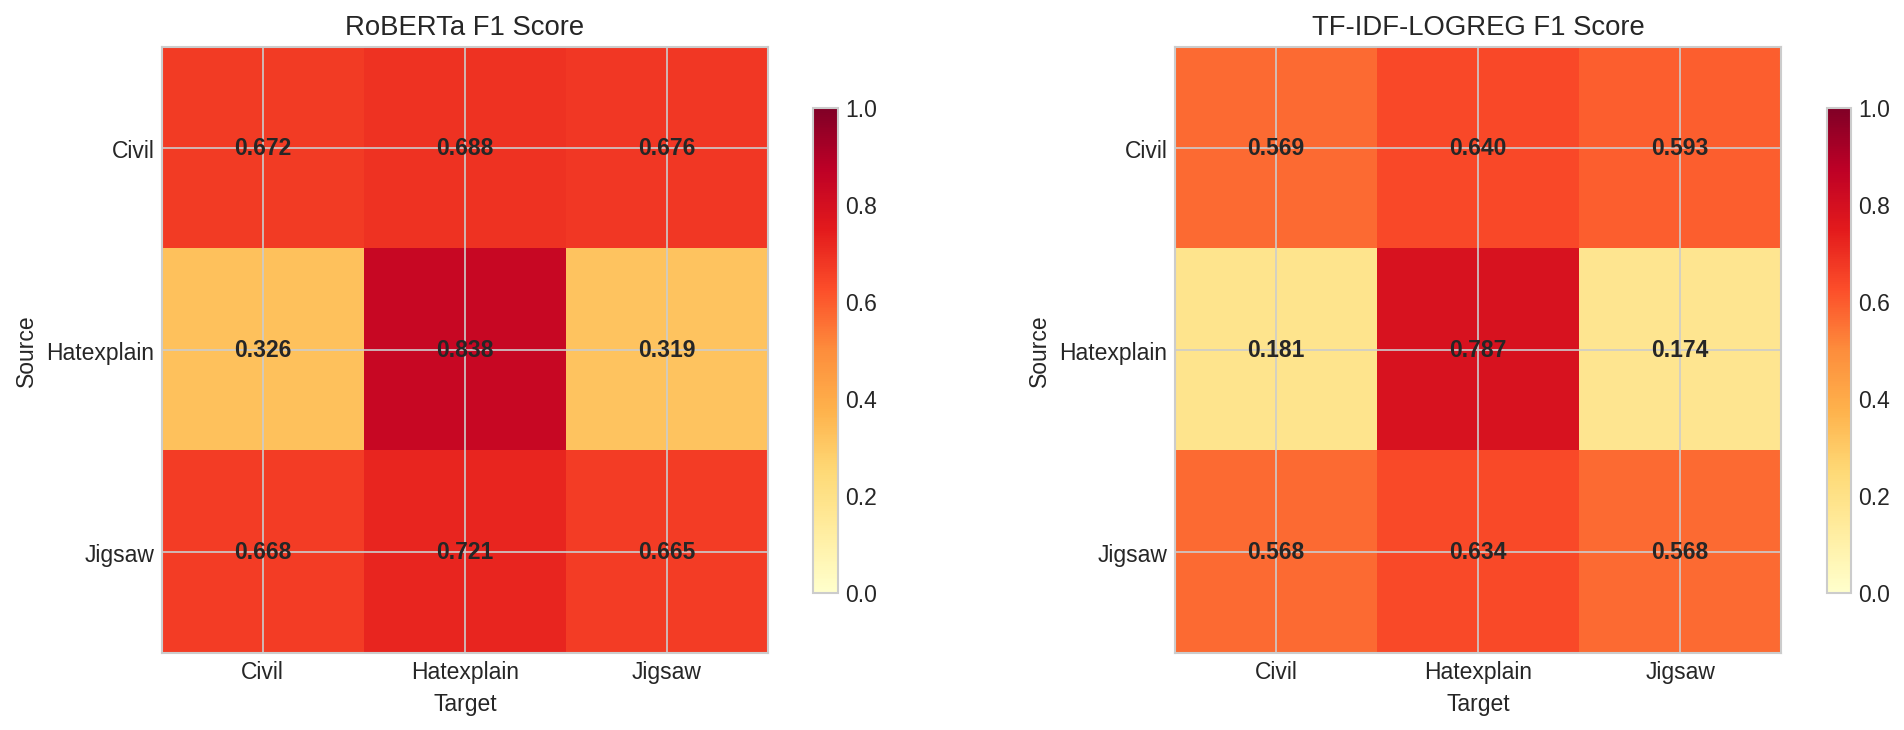

In [14]:
# =============================================================================
# CELL 12: Plot 1 - Classification Performance Heatmaps
# =============================================================================

print("Generating Classification Heatmaps...")

class_df = results.get_df('classification')

if len(class_df) > 0:
    fig, axes = plt.subplots(1, 2, figsize=(14, 5))

    for ax, model in zip(axes, ['RoBERTa', 'TF-IDF-LOGREG']):
        df = class_df[class_df['model'] == model]
        if len(df) == 0:
            continue

        # Create pivot table
        pivot = df.pivot_table(index='source', columns='target', values='f1', aggfunc='mean')

        im = ax.imshow(pivot.values, cmap='YlOrRd', vmin=0, vmax=1)
        ax.set_xticks(range(len(pivot.columns)))
        ax.set_yticks(range(len(pivot.index)))
        ax.set_xticklabels([c.capitalize() for c in pivot.columns])
        ax.set_yticklabels([c.capitalize() for c in pivot.index])
        ax.set_xlabel('Target')
        ax.set_ylabel('Source')
        ax.set_title(f'{model} F1 Score')

        # Annotate
        for i in range(len(pivot.index)):
            for j in range(len(pivot.columns)):
                val = pivot.values[i, j]
                if not np.isnan(val):
                    ax.text(j, i, f'{val:.3f}', ha='center', va='center', fontweight='bold', fontsize=11)

        plt.colorbar(im, ax=ax, shrink=0.8)

    plt.tight_layout()
    save_fig(fig, 'classification_heatmaps')
    plt.show()
else:
    print("  No classification results to plot")

Generating ROC & PR Curves...
  ✓ Saved roc_pr_curves


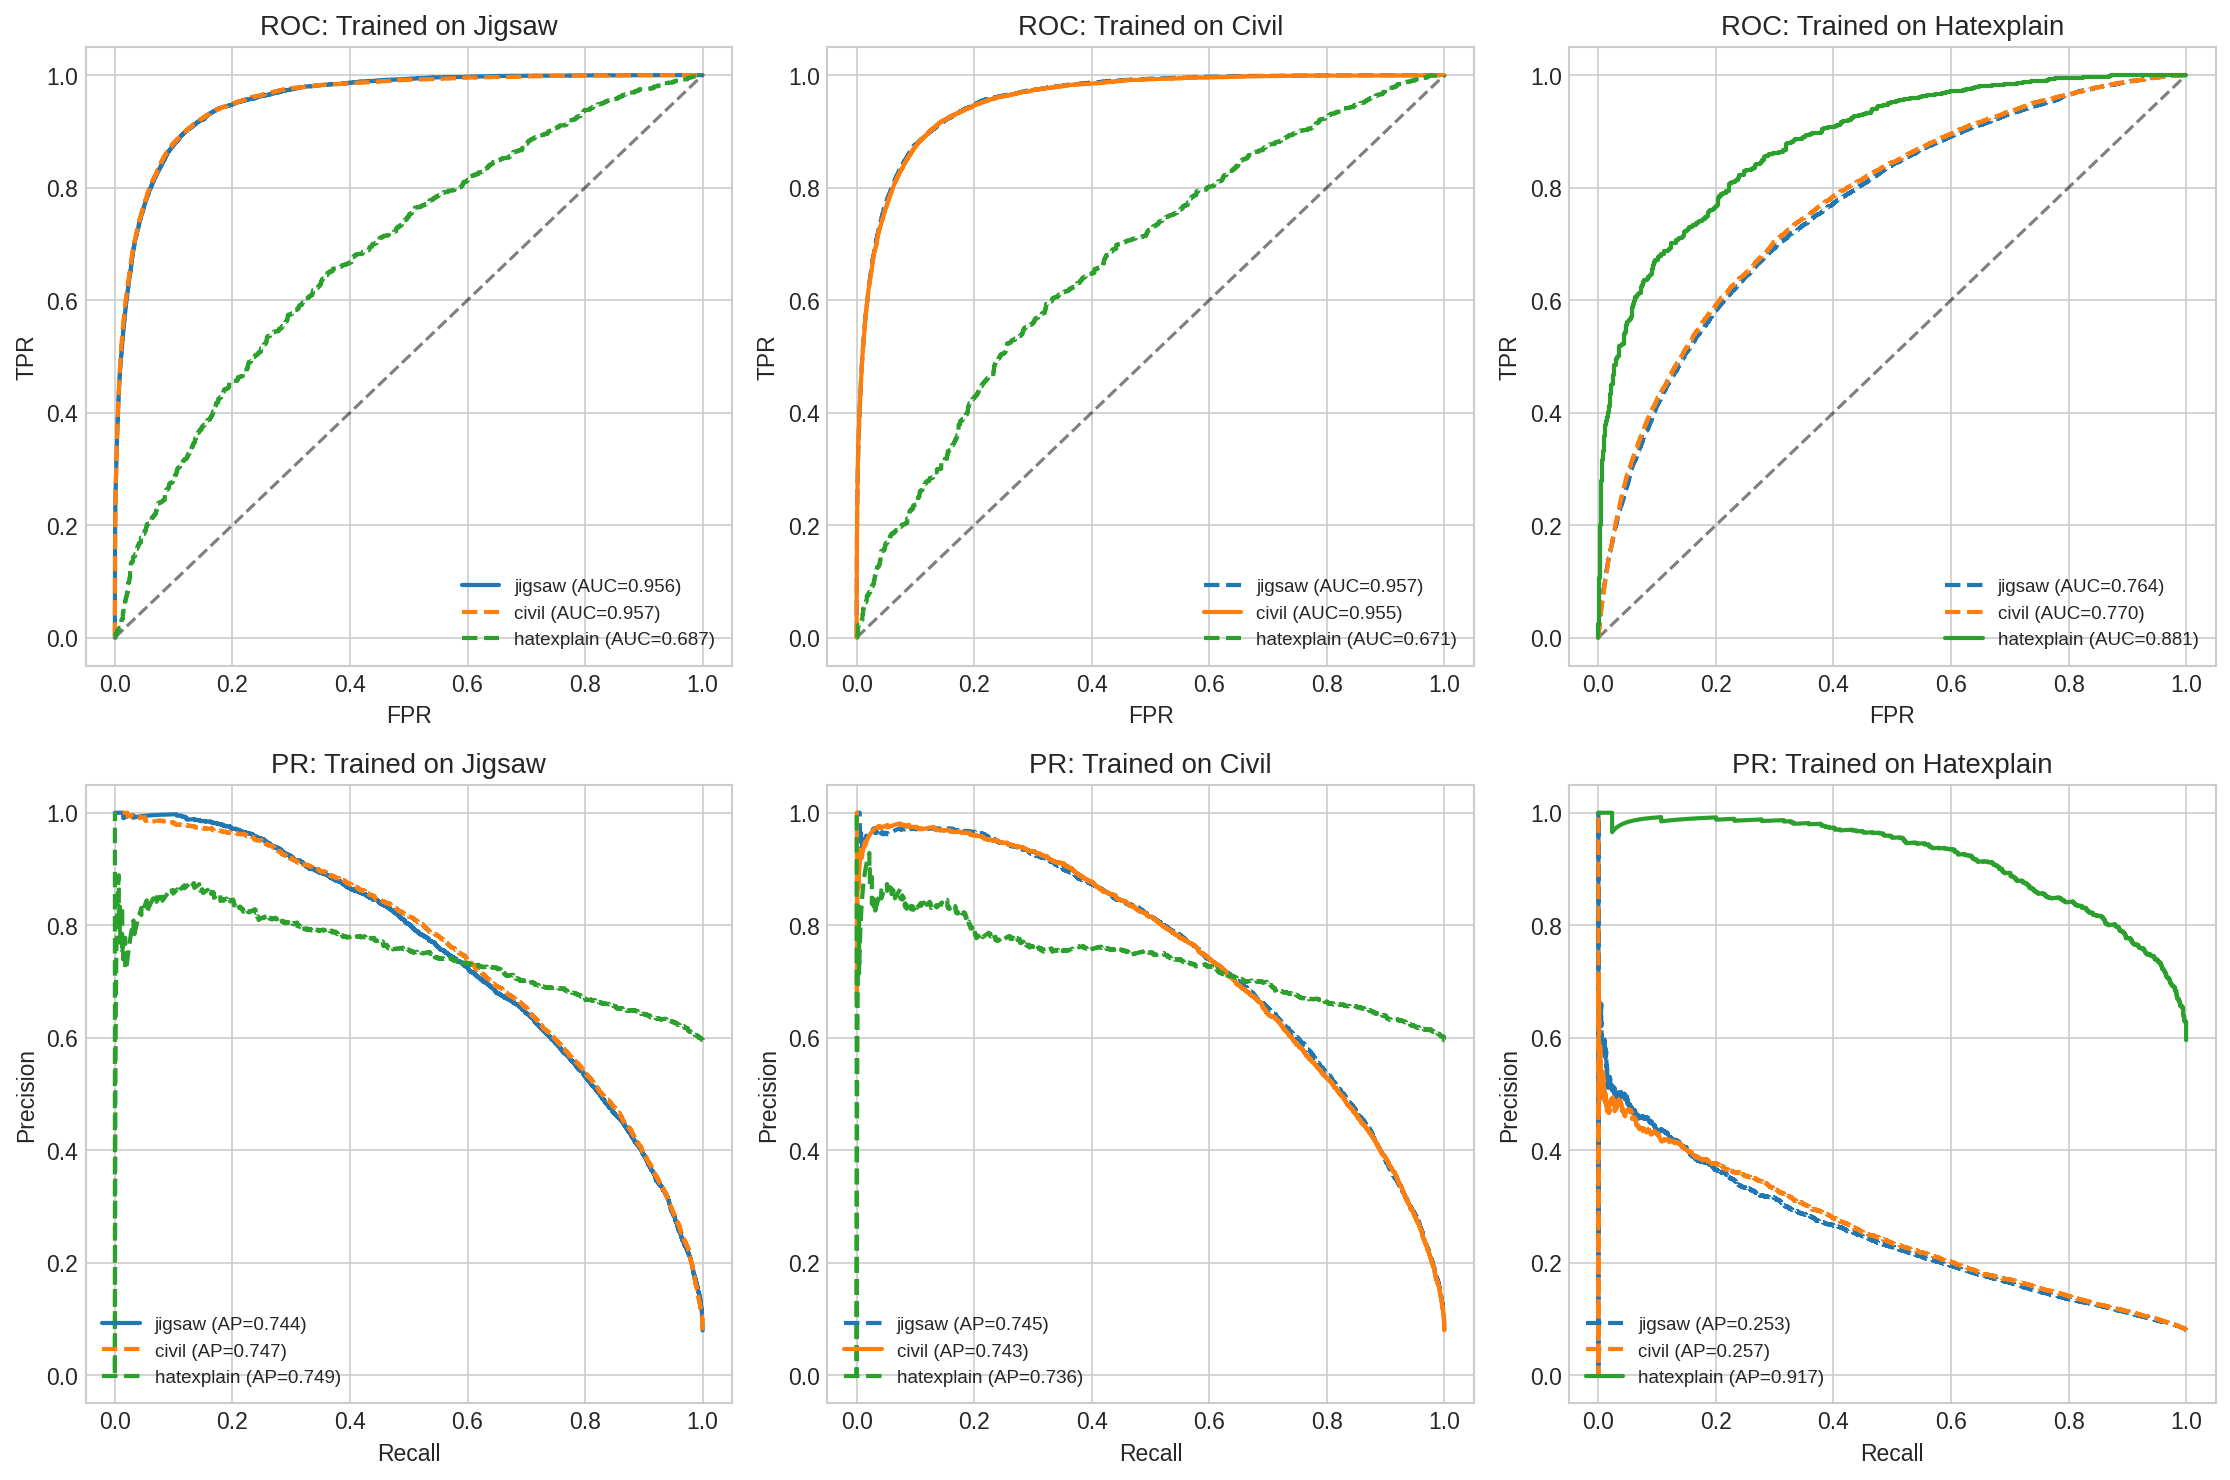

In [15]:
# =============================================================================
# CELL 13: Plot 2 - ROC & PR Curves
# =============================================================================

print("Generating ROC & PR Curves...")

fig, axes = plt.subplots(2, 3, figsize=(15, 10))

for idx, source in enumerate(CONFIG['datasets']):
    ax_roc = axes[0, idx]
    ax_pr = axes[1, idx]

    ax_roc.plot([0, 1], [0, 1], 'k--', alpha=0.5)

    for target in CONFIG['datasets']:
        key = f"{source}_to_{target}"
        if key not in eval_results or eval_results[key]['probs'] is None:
            continue

        probs = eval_results[key]['probs']
        labels = eval_results[key]['labels']

        # ROC
        fpr, tpr, _ = roc_curve(labels, probs)
        auc = roc_auc_score(labels, probs)
        style = '-' if source == target else '--'
        ax_roc.plot(fpr, tpr, style, label=f'{target} (AUC={auc:.3f})', color=COLORS[target], linewidth=2)

        # PR
        prec, rec, _ = precision_recall_curve(labels, probs)
        ap = average_precision_score(labels, probs)
        ax_pr.plot(rec, prec, style, label=f'{target} (AP={ap:.3f})', color=COLORS[target], linewidth=2)

    ax_roc.set_xlabel('FPR')
    ax_roc.set_ylabel('TPR')
    ax_roc.set_title(f'ROC: Trained on {source.capitalize()}')
    ax_roc.legend(loc='lower right', fontsize=9)

    ax_pr.set_xlabel('Recall')
    ax_pr.set_ylabel('Precision')
    ax_pr.set_title(f'PR: Trained on {source.capitalize()}')
    ax_pr.legend(loc='lower left', fontsize=9)

plt.tight_layout()
save_fig(fig, 'roc_pr_curves')
plt.show()

Generating Calibration Plots...
  ✓ Saved calibration_reliability


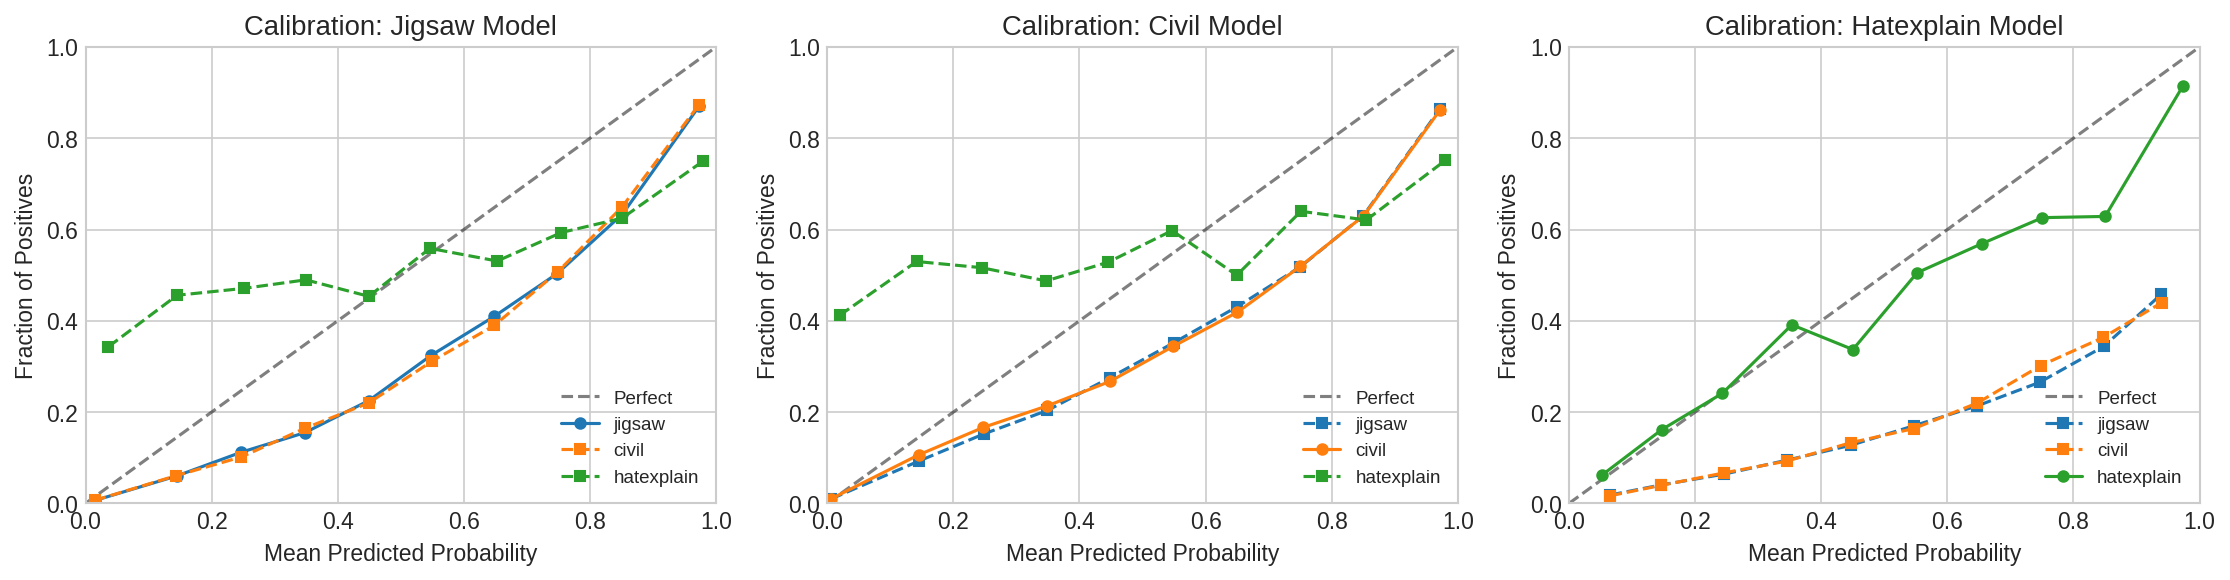

In [16]:
# =============================================================================
# CELL 14: Plot 3 - Calibration Reliability Diagrams
# =============================================================================

from sklearn.calibration import calibration_curve

print("Generating Calibration Plots...")

fig, axes = plt.subplots(1, 3, figsize=(15, 4))

for idx, source in enumerate(CONFIG['datasets']):
    ax = axes[idx]
    ax.plot([0, 1], [0, 1], 'k--', label='Perfect', alpha=0.5)

    for target in CONFIG['datasets']:
        key = f"{source}_to_{target}"
        if key not in calibration_results:
            continue

        probs = calibration_results[key]['uncal']
        labels = calibration_results[key]['labels']

        if probs is None or len(probs) == 0:
            continue

        prob_true, prob_pred = calibration_curve(labels, probs, n_bins=10, strategy='uniform')
        style = '-o' if source == target else '--s'
        ax.plot(prob_pred, prob_true, style, label=f'{target}', color=COLORS[target], markersize=5)

    ax.set_xlabel('Mean Predicted Probability')
    ax.set_ylabel('Fraction of Positives')
    ax.set_title(f'Calibration: {source.capitalize()} Model')
    ax.legend(loc='lower right', fontsize=9)
    ax.set_xlim([0, 1])
    ax.set_ylim([0, 1])

plt.tight_layout()
save_fig(fig, 'calibration_reliability')
plt.show()

Generating OOD Detection & Fairness Plots...
  ✓ Saved ood_fairness


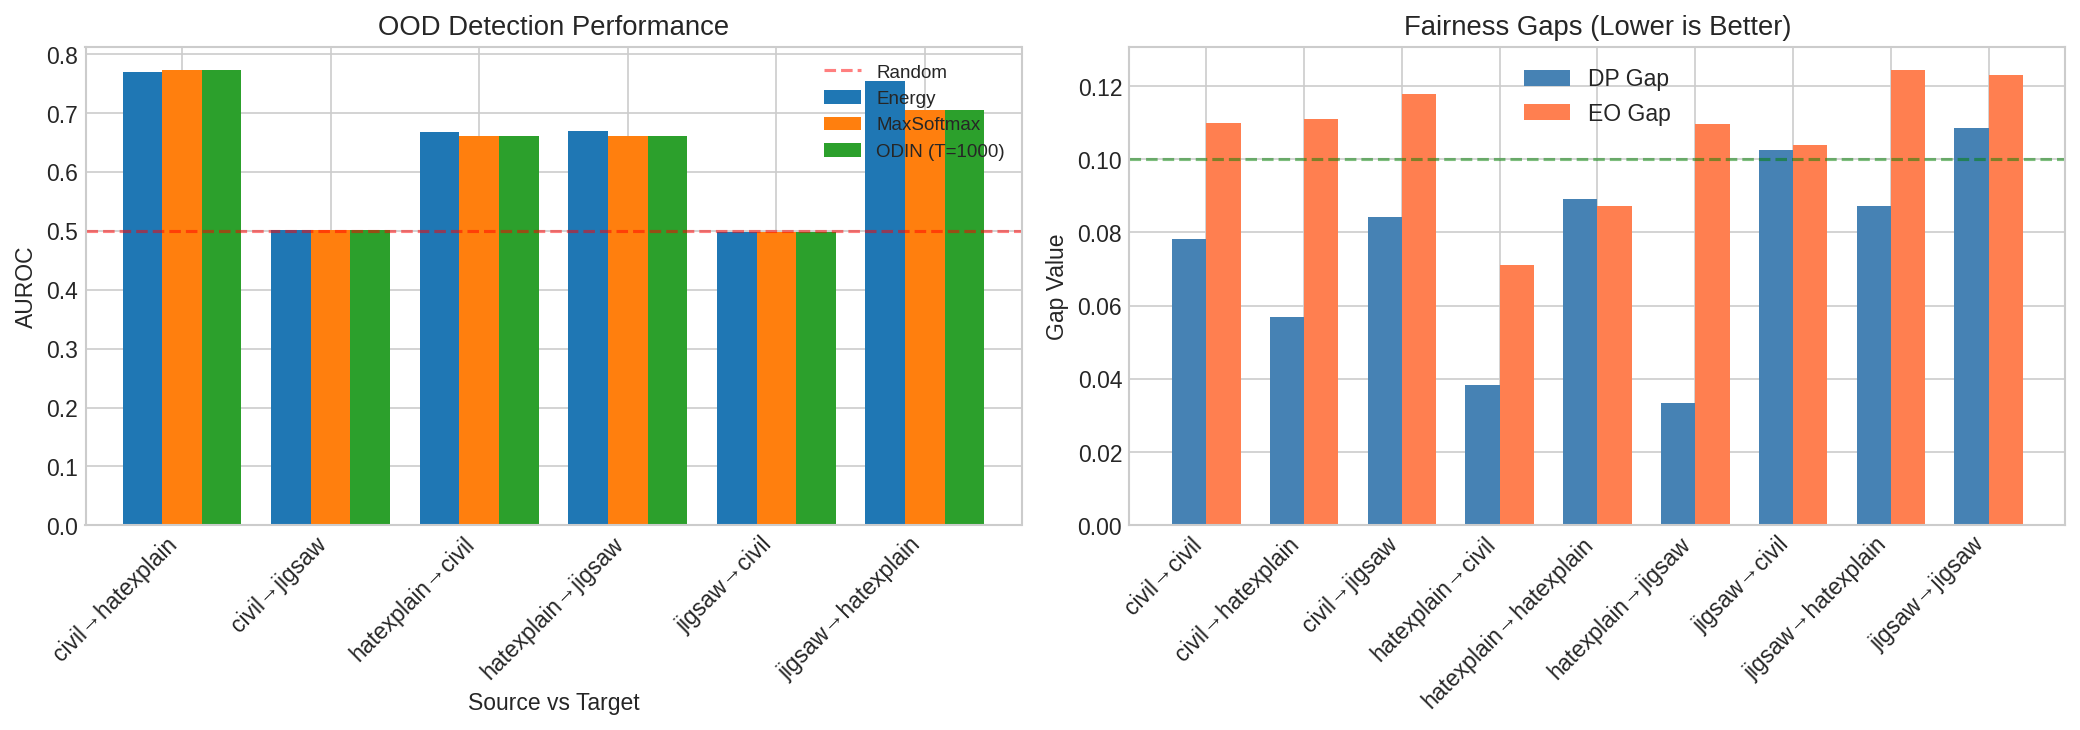

In [17]:
# =============================================================================
# CELL 15: Plot 4 - OOD Detection & Fairness
# =============================================================================

print("Generating OOD Detection & Fairness Plots...")

fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# OOD Detection
ood_df = results.get_df('ood')
if len(ood_df) > 0:
    ax = axes[0]
    pivot = ood_df.pivot_table(index=['source', 'target'], columns='method', values='auroc')
    pivot.plot(kind='bar', ax=ax, width=0.8)
    ax.set_xlabel('Source vs Target')
    ax.set_ylabel('AUROC')
    ax.set_title('OOD Detection Performance')
    ax.axhline(y=0.5, color='red', linestyle='--', alpha=0.5, label='Random')
    ax.legend(loc='upper right', fontsize=9)
    ax.set_xticklabels([f"{s}→{t}" for s, t in pivot.index], rotation=45, ha='right')
else:
    axes[0].text(0.5, 0.5, 'No OOD results', ha='center', va='center')
    axes[0].set_title('OOD Detection')

# Fairness
fair_df = results.get_df('fairness')
if len(fair_df) > 0:
    ax = axes[1]
    # Aggregate by source-target pair
    agg = fair_df.groupby(['source', 'target'])[['dp_diff', 'eo_diff']].mean().reset_index()
    agg['pair'] = agg['source'] + '→' + agg['target']

    x = np.arange(len(agg))
    width = 0.35
    ax.bar(x - width/2, agg['dp_diff'], width, label='DP Gap', color='steelblue')
    ax.bar(x + width/2, agg['eo_diff'], width, label='EO Gap', color='coral')
    ax.set_xticks(x)
    ax.set_xticklabels(agg['pair'], rotation=45, ha='right')
    ax.set_ylabel('Gap Value')
    ax.set_title('Fairness Gaps (Lower is Better)')
    ax.axhline(y=0.1, color='green', linestyle='--', alpha=0.5)
    ax.legend()
else:
    axes[1].text(0.5, 0.5, 'No fairness results', ha='center', va='center')
    axes[1].set_title('Fairness Gaps')

plt.tight_layout()
save_fig(fig, 'ood_fairness')
plt.show()

In [ ]:
# =============================================================================
# CELL 16: Plot 5 - Training Curves
# =============================================================================

print("Generating Training Curves...")

if training_histories:
    n = len(training_histories)
    fig, axes = plt.subplots(1, n, figsize=(5*n, 4))
    if n == 1:
        axes = [axes]

    for ax, (source, hist) in zip(axes, training_histories.items()):
        epochs = range(1, len(hist['train_loss']) + 1)

        ax.plot(epochs, hist['train_loss'], 'b-', label='Train Loss', linewidth=2)
        ax.plot(epochs, hist['val_loss'], 'r-', label='Val Loss', linewidth=2)

        ax2 = ax.twinx()
        ax2.plot(epochs, hist['val_f1'], 'g--', label='Val F1', linewidth=2)
        ax2.set_ylabel('F1 Score', color='green')
        ax2.tick_params(axis='y', labelcolor='green')

        ax.set_xlabel('Epoch')
        ax.set_ylabel('Loss')
        ax.set_title(f'Training: {source.capitalize()}')
        ax.legend(loc='upper left')
        ax2.legend(loc='upper right')

    plt.tight_layout()
    save_fig(fig, 'training_curves')
    plt.show()
else:
    print("  No training histories to plot")

In [ ]:
print("="*60)
print("CALIBRATION DEBUG")
print("="*60)

for source in CONFIG['datasets']:
    for target in CONFIG['datasets']:
        key = f"{source}_to_{target}"
        if key not in eval_results or eval_results[key]['probs'] is None:
            continue

        probs = eval_results[key]['probs']
        labels = eval_results[key]['labels']

        print(f"\n{source}→{target}:")
        print(f"  Label distribution: {labels.mean():.1%} positive")
        print(f"  Prob stats: min={probs.min():.3f}, max={probs.max():.3f}, mean={probs.mean():.3f}")
        print(f"  Prob quartiles: 25%={np.percentile(probs, 25):.3f}, 50%={np.percentile(probs, 50):.3f}, 75%={np.percentile(probs, 75):.3f}")

        # Check predictions
        preds = (probs >= 0.5).astype(int)
        print(f"  Predicted positive: {preds.mean():.1%}")

CALIBRATION DEBUG

jigsaw→jigsaw:
  Label distribution: 8.0% positive
  Prob stats: min=0.001, max=0.996, mean=0.123
  Prob quartiles: 25%=0.003, 50%=0.010, 75%=0.086
  Predicted positive: 9.6%

jigsaw→civil:
  Label distribution: 8.0% positive
  Prob stats: min=0.001, max=0.996, mean=0.123
  Prob quartiles: 25%=0.003, 50%=0.010, 75%=0.081
  Predicted positive: 9.7%

jigsaw→hatexplain:
  Label distribution: 59.6% positive
  Prob stats: min=0.002, max=0.996, mean=0.645
  Prob quartiles: 25%=0.305, 50%=0.782, 75%=0.990
  Predicted positive: 65.6%

civil→jigsaw:
  Label distribution: 8.0% positive
  Prob stats: min=0.000, max=0.996, mean=0.101
  Prob quartiles: 25%=0.000, 50%=0.001, 75%=0.026
  Predicted positive: 8.6%

civil→civil:
  Label distribution: 8.0% positive
  Prob stats: min=0.000, max=0.996, mean=0.100
  Prob quartiles: 25%=0.000, 50%=0.001, 75%=0.024
  Predicted positive: 8.5%

civil→hatexplain:
  Label distribution: 59.6% positive
  Prob stats: min=0.000, max=0.996, mean=0.5

In [35]:
# =============================================================================
# CELL: Fixed ECE Calculation for Imbalanced Data
# =============================================================================

def adaptive_ece(y_true, y_prob, n_bins=10, strategy='quantile'):
    """
    ECE that works for imbalanced data.
    strategy: 'quantile' (equal samples per bin) or 'uniform' (equal width bins)
    """
    y_true = np.array(y_true)
    y_prob = np.array(y_prob)

    if strategy == 'quantile':
        # Equal number of samples per bin
        quantiles = np.linspace(0, 100, n_bins + 1)
        bins = np.percentile(y_prob, quantiles)
        bins = np.unique(bins)  # Remove duplicates
    else:
        bins = np.linspace(0, 1, n_bins + 1)

    ece = 0.0
    bin_data = []

    for i in range(len(bins) - 1):
        mask = (y_prob >= bins[i]) & (y_prob < bins[i+1])
        if i == len(bins) - 2:  # Include right edge for last bin
            mask = (y_prob >= bins[i]) & (y_prob <= bins[i+1])

        if mask.sum() > 0:
            bin_acc = y_true[mask].mean()
            bin_conf = y_prob[mask].mean()
            bin_size = mask.sum()

            ece += (bin_size / len(y_prob)) * abs(bin_acc - bin_conf)
            bin_data.append({
                'bin': f'{bins[i]:.2f}-{bins[i+1]:.2f}',
                'samples': bin_size,
                'accuracy': bin_acc,
                'confidence': bin_conf,
                'gap': abs(bin_acc - bin_conf)
            })

    return ece, pd.DataFrame(bin_data)

# Recalculate ECE with adaptive binning
print("="*60)
print("FIXED ECE (Quantile Binning)")
print("="*60)

for source in CONFIG['datasets']:
    for target in CONFIG['datasets']:
        key = f"{source}_to_{target}"
        if key not in eval_results or eval_results[key]['probs'] is None:
            continue

        probs = eval_results[key]['probs']
        labels = eval_results[key]['labels']

        ece_uniform, _ = adaptive_ece(labels, probs, strategy='uniform')
        ece_quantile, _ = adaptive_ece(labels, probs, strategy='quantile')

        print(f"{source}→{target}: ECE(uniform)={ece_uniform:.4f}, ECE(quantile)={ece_quantile:.4f}")

FIXED ECE (Quantile Binning)
jigsaw→jigsaw: ECE(uniform)=0.0435, ECE(quantile)=0.0435
jigsaw→civil: ECE(uniform)=0.0432, ECE(quantile)=0.0432
jigsaw→hatexplain: ECE(uniform)=0.2077, ECE(quantile)=0.2096
civil→jigsaw: ECE(uniform)=0.0271, ECE(quantile)=0.0278
civil→civil: ECE(uniform)=0.0263, ECE(quantile)=0.0267
civil→hatexplain: ECE(uniform)=0.2572, ECE(quantile)=0.2480
hatexplain→jigsaw: ECE(uniform)=0.1792, ECE(quantile)=0.1792
hatexplain→civil: ECE(uniform)=0.1773, ECE(quantile)=0.1773
hatexplain→hatexplain: ECE(uniform)=0.0667, ECE(quantile)=0.0647


In [36]:
# =============================================================================
# CELL: Selective Prediction
# =============================================================================

def selective_predict_fixed(probs, labels, ood_scores, rejection_percentiles=[0, 10, 20, 30, 50]):
    """
    Reject samples with highest OOD scores.
    For Energy: MORE NEGATIVE = more OOD, so we reject the LOWEST scores.
    """
    results = []
    preds = (probs >= 0.5).astype(int)

    for pct in rejection_percentiles:
        if pct == 0:
            mask = np.ones(len(probs), dtype=bool)
        else:
            # For Energy: reject samples with LOWEST scores (most negative = most OOD)
            threshold = np.percentile(ood_scores, pct)  # Changed from 100-pct
            mask = ood_scores >= threshold  # Changed from <=

        if mask.sum() < 10:
            continue

        f1 = f1_score(labels[mask], preds[mask])
        acc = accuracy_score(labels[mask], preds[mask])
        coverage = mask.mean()

        results.append({
            'reject_pct': pct,
            'coverage': coverage,
            'f1': f1,
            'accuracy': acc,
            'n_samples': mask.sum()
        })

    return pd.DataFrame(results)

# Re-run with fixed logic
print("="*60)
print("SELECTIVE PREDICTION")
print("="*60)

energy_detector = EnergyOOD()

for source in CONFIG['datasets']:
    for target in CONFIG['datasets']:
        if source == target:
            continue

        key = f"{source}_to_{target}"
        if key not in eval_results or eval_results[key]['logits'] is None:
            continue

        logits = eval_results[key]['logits']
        probs = eval_results[key]['probs']
        labels = eval_results[key]['labels']

        ood_scores = energy_detector.compute_scores(logits)

        print(f"\n{source}→{target}:")
        print(f"  Energy score range: [{ood_scores.min():.2f}, {ood_scores.max():.2f}]")

        sel_df = selective_predict_fixed(probs, labels, ood_scores)
        print(sel_df.to_string(index=False))

        if len(sel_df) > 1:
            base_f1 = sel_df.iloc[0]['f1']
            best_f1 = sel_df['f1'].max()
            best_row = sel_df.loc[sel_df['f1'].idxmax()]
            print(f"  → Best: F1={best_f1:.4f} at {best_row['coverage']*100:.0f}% coverage (+{(best_f1-base_f1)*100:.1f}%)")

SELECTIVE PREDICTION

jigsaw→civil:
  Energy score range: [-3.86, -0.62]
 reject_pct  coverage       f1  accuracy  n_samples
          0  1.000000 0.667756  0.941118      96702
         10  0.899992 0.667756  0.934575      87031
         20  0.799994 0.668029  0.926488      77361
         30  0.699996 0.668692  0.916237      67691
         50  0.500000 0.670928  0.883953      48351
  → Best: F1=0.6709 at 50% coverage (+0.3%)

jigsaw→hatexplain:
  Energy score range: [-3.31, -0.68]
 reject_pct  coverage       f1  accuracy  n_samples
          0  1.000000 0.721494  0.651417       2011
         10  0.900050 0.702775  0.633149       1810
         20  0.800099 0.671226  0.611560       1609
         30  0.700149 0.643750  0.595170       1408
         50  0.500249 0.619469  0.572565       1006
  → Best: F1=0.7215 at 100% coverage (+0.0%)

civil→jigsaw:
  Energy score range: [-4.19, -0.71]
 reject_pct  coverage       f1  accuracy  n_samples
          0       1.0 0.675796  0.946469      89780
 

In [37]:
# =============================================================================
# CELL: OOD-Adjusted Confidence
# =============================================================================

def ood_adjusted_confidence(probs, ood_scores, method='scale'):
    """
    Reduce confidence for high OOD samples.

    Methods:
    - 'scale': Multiply prob by (1 - normalized_ood_score)
    - 'temperature': Apply temperature scaling based on OOD
    """
    # Normalize OOD scores to [0, 1]
    ood_norm = (ood_scores - ood_scores.min()) / (ood_scores.max() - ood_scores.min() + 1e-8)

    if method == 'scale':
        # High OOD → reduce confidence toward 0.5
        adjustment = 1 - ood_norm * 0.5  # Scale factor between 0.5 and 1
        adjusted = 0.5 + (probs - 0.5) * adjustment

    elif method == 'temperature':
        # High OOD → higher temperature → softer predictions
        temperatures = 1 + ood_norm * 2  # T between 1 and 3
        logits = np.log(probs / (1 - probs + 1e-8))  # Convert to logits
        adjusted = 1 / (1 + np.exp(-logits / temperatures))

    return adjusted, ood_norm

print("="*60)
print("OOD-ADJUSTED CONFIDENCE CALIBRATION")
print("="*60)

for source in CONFIG['datasets']:
    for target in CONFIG['datasets']:
        if source == target:
            continue

        key = f"{source}_to_{target}"
        if key not in eval_results or eval_results[key]['logits'] is None:
            continue

        logits = eval_results[key]['logits']
        probs = eval_results[key]['probs']
        labels = eval_results[key]['labels']

        ood_scores = energy_detector.compute_scores(logits)
        adjusted_probs, _ = ood_adjusted_confidence(probs, ood_scores, method='scale')

        # Compare ECE
        ece_orig, _ = adaptive_ece(labels, probs, strategy='quantile')
        ece_adj, _ = adaptive_ece(labels, adjusted_probs, strategy='quantile')

        # Compare Brier score (lower is better)
        brier_orig = brier_score_loss(labels, probs)
        brier_adj = brier_score_loss(labels, adjusted_probs)

        print(f"{source}→{target}:")
        print(f"  ECE:   {ece_orig:.4f} → {ece_adj:.4f} ({'✓' if ece_adj < ece_orig else '✗'})")
        print(f"  Brier: {brier_orig:.4f} → {brier_adj:.4f} ({'✓' if brier_adj < brier_orig else '✗'})")

OOD-ADJUSTED CONFIDENCE CALIBRATION
jigsaw→civil:
  ECE:   0.0432 → 0.1100 (✗)
  Brier: 0.0433 → 0.0547 (✗)
jigsaw→hatexplain:
  ECE:   0.2096 → 0.1062 (✓)
  Brier: 0.2676 → 0.2299 (✓)
civil→jigsaw:
  ECE:   0.0278 → 0.0663 (✗)
  Brier: 0.0401 → 0.0452 (✗)
civil→hatexplain:
  ECE:   0.2480 → 0.1462 (✓)
  Brier: 0.2975 → 0.2516 (✓)
hatexplain→jigsaw:
  ECE:   0.1792 → 0.2492 (✗)
  Brier: 0.1162 → 0.1352 (✗)
hatexplain→civil:
  ECE:   0.1773 → 0.2497 (✗)
  Brier: 0.1145 → 0.1346 (✗)


In [ ]:
# =============================================================================
# CELL:  OOD-Weighted Ensemble
# =============================================================================

def ood_weighted_ensemble_fixed(target_dataset):
    """
    Weight predictions inversely by OOD score.
    For Energy: more negative = more OOD = lower weight.
    """
    all_probs = []
    all_weights = []
    labels = None
    source_names = []

    for source in roberta_models:
        key = f"{source}_to_{target_dataset}"
        if key not in eval_results or eval_results[key]['probs'] is None:
            continue

        probs = eval_results[key]['probs']
        logits = eval_results[key]['logits']
        labels = eval_results[key]['labels']

        ood_scores = energy_detector.compute_scores(logits)
        mean_ood = ood_scores.mean()

        # FIX: For Energy, higher (less negative) = more in-distribution
        # Shift to positive range first
        weight = mean_ood - ood_scores.min() + 1  # Shift to positive

        all_probs.append(probs)
        all_weights.append(weight)
        source_names.append(source)
        print(f"  {source}→{target_dataset}: mean_OOD={mean_ood:.2f}, weight={weight:.3f}")

    if len(all_probs) == 0:
        return None, None, None, None

    # Normalize weights
    weights = np.array(all_weights)
    weights = weights / weights.sum()

    print(f"  Normalized weights: {dict(zip(source_names, weights.round(3)))}")

    # Weighted average
    ensemble_probs = np.zeros_like(all_probs[0])
    for prob, w in zip(all_probs, weights):
        ensemble_probs += w * prob

    return ensemble_probs, labels, weights, source_names

print("="*60)
print("OOD-WEIGHTED ENSEMBLE")
print("="*60)

for target in CONFIG['datasets']:
    print(f"\nTarget: {target.upper()}")
    ens_probs, labels, weights, sources = ood_weighted_ensemble_fixed(target)

    if ens_probs is None:
        continue

    ens_preds = (ens_probs >= 0.5).astype(int)
    ens_f1 = f1_score(labels, ens_preds)

    # Simple average baseline
    simple_avg = np.mean([eval_results[f"{s}_to_{target}"]['probs']
                          for s in roberta_models
                          if f"{s}_to_{target}" in eval_results], axis=0)
    simple_f1 = f1_score(labels, (simple_avg >= 0.5).astype(int))

    # Best individual
    best_f1, best_source = 0, None
    for source in roberta_models:
        key = f"{source}_to_{target}"
        if key in eval_results and eval_results[key]['probs'] is not None:
            f1 = f1_score(labels, (eval_results[key]['probs'] >= 0.5).astype(int))
            if f1 > best_f1:
                best_f1, best_source = f1, source

    print(f"  Results:")
    print(f"    Best individual ({best_source}): F1={best_f1:.4f}")
    print(f"    Simple average ensemble:         F1={simple_f1:.4f}")
    print(f"    OOD-weighted ensemble:           F1={ens_f1:.4f}")

OOD-WEIGHTED ENSEMBLE

Target: JIGSAW
  jigsaw→jigsaw: mean_OOD=-2.34, weight=2.534
  civil→jigsaw: mean_OOD=-3.01, weight=2.179
  hatexplain→jigsaw: mean_OOD=-1.18, weight=2.202
  Normalized weights: {'jigsaw': np.float32(0.366), 'civil': np.float32(0.315), 'hatexplain': np.float32(0.318)}
  Results:
    Best individual (civil): F1=0.6758
    Simple average ensemble:         F1=0.6720
    OOD-weighted ensemble:           F1=0.6737

Target: CIVIL
  jigsaw→civil: mean_OOD=-2.35, weight=2.512
  civil→civil: mean_OOD=-3.02, weight=2.192
  hatexplain→civil: mean_OOD=-1.19, weight=2.320
  Normalized weights: {'jigsaw': np.float32(0.358), 'civil': np.float32(0.312), 'hatexplain': np.float32(0.33)}
  Results:
    Best individual (civil): F1=0.6718
    Simple average ensemble:         F1=0.6764
    OOD-weighted ensemble:           F1=0.6762

Target: HATEXPLAIN
  jigsaw→hatexplain: mean_OOD=-1.50, weight=2.807
  civil→hatexplain: mean_OOD=-1.96, weight=3.145
  hatexplain→hatexplain: mean_OOD=-1

Generating OOD Score Distributions...
  ✓ Saved ood_score_distributions


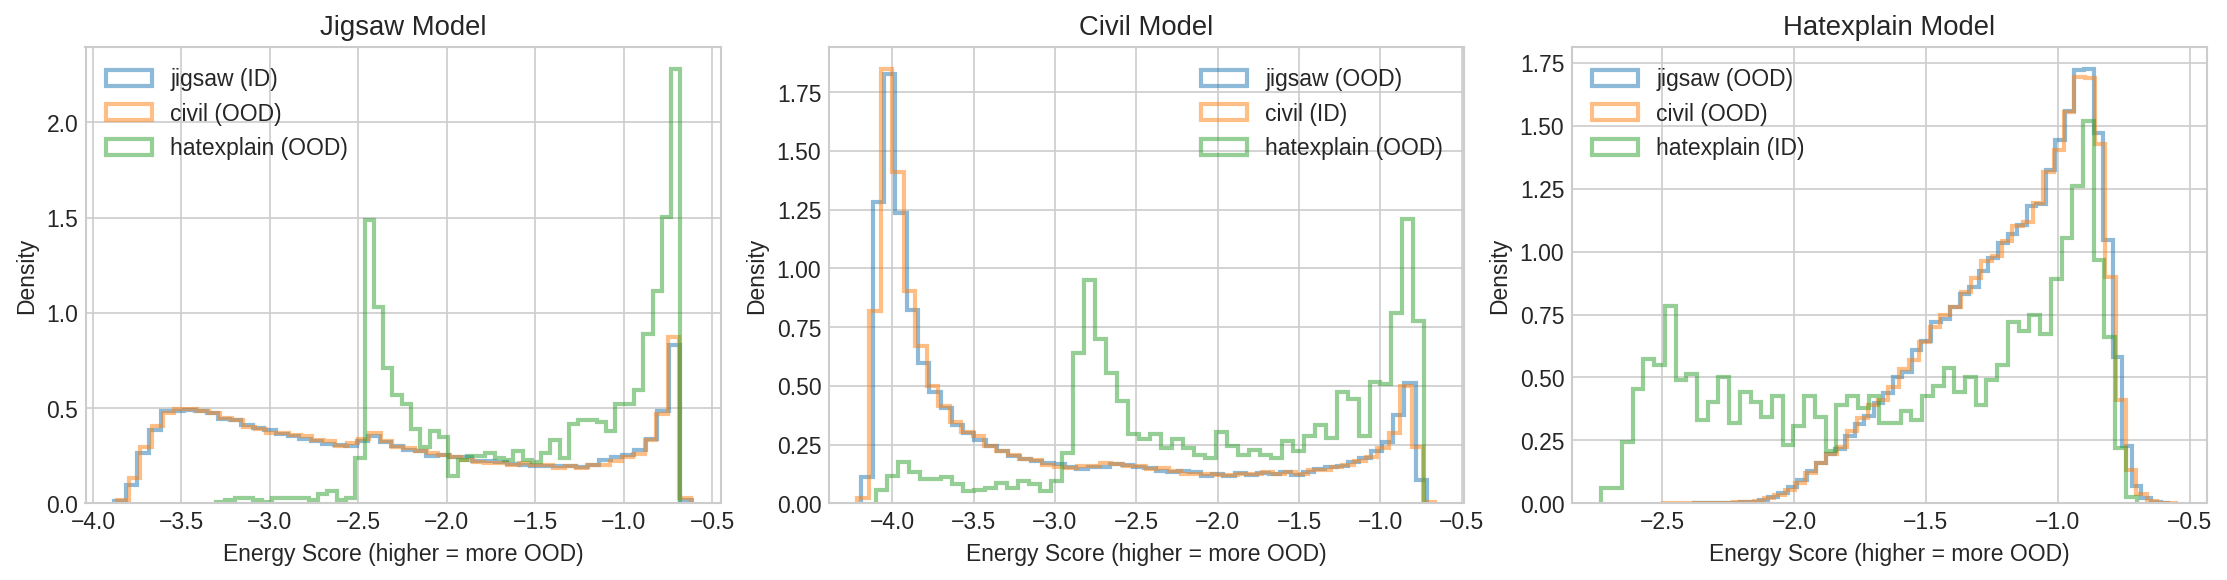

In [42]:
# =============================================================================
# CELL: OOD Score Distribution Plot
# =============================================================================

print("Generating OOD Score Distributions...")

fig, axes = plt.subplots(1, 3, figsize=(15, 4))

for idx, source in enumerate(CONFIG['datasets']):
    ax = axes[idx]

    for target in CONFIG['datasets']:
        key = f"{source}_to_{target}"
        if key not in eval_results or eval_results[key]['logits'] is None:
            continue

        logits = eval_results[key]['logits']
        ood_scores = energy_detector.compute_scores(logits)

        style = '-' if source == target else '--'
        label = f'{target} (ID)' if source == target else f'{target} (OOD)'
        ax.hist(ood_scores, bins=50, alpha=0.5, label=label,
                color=COLORS[target], density=True, histtype='step', linewidth=2)

    ax.set_xlabel('Energy Score (higher = more OOD)')
    ax.set_ylabel('Density')
    ax.set_title(f'{source.capitalize()} Model')
    ax.legend()

plt.tight_layout()
save_fig(fig, 'ood_score_distributions')
plt.show()

In [43]:
# =============================================================================
# CELL: Practical OOD Application - Shift Detection & Alerting
# =============================================================================

print("="*60)
print("PRACTICAL OOD APPLICATION: DOMAIN SHIFT DETECTION")
print("="*60)

def detect_domain_shift(source_model, source_data_key, new_data_key, threshold_auroc=0.60):
    """
    Detect if new data is from a different distribution than training data.
    Returns: is_shifted (bool), confidence (AUROC), recommendation (str)
    """
    if source_data_key not in eval_results or new_data_key not in eval_results:
        return None, None, "Insufficient data"

    id_logits = eval_results[source_data_key]['logits']
    new_logits = eval_results[new_data_key]['logits']

    if id_logits is None or new_logits is None:
        return None, None, "No logits available"

    # Compute OOD detection AUROC
    y_true = np.concatenate([np.ones(len(id_logits)), np.zeros(len(new_logits))])
    all_logits = np.vstack([id_logits, new_logits])

    scores = -energy_detector.compute_scores(all_logits)
    auroc = roc_auc_score(y_true, scores)

    # Decision logic
    if auroc > 0.70:
        is_shifted = True
        recommendation = "⚠️ SIGNIFICANT SHIFT: Consider retraining or using domain-specific model"
    elif auroc > threshold_auroc:
        is_shifted = True
        recommendation = "⚡ MODERATE SHIFT: Monitor performance, consider calibration"
    else:
        is_shifted = False
        recommendation = "✅ NO SIGNIFICANT SHIFT: Model likely reliable"

    return is_shifted, auroc, recommendation

# Test on all pairs
print("\nDomain Shift Detection Results:")
print("-" * 70)

for source in CONFIG['datasets']:
    source_key = f"{source}_to_{source}"

    for target in CONFIG['datasets']:
        if source == target:
            continue

        target_key = f"{source}_to_{target}"
        is_shifted, auroc, rec = detect_domain_shift(source, source_key, target_key)

        if auroc is not None:
            print(f"\n{source.upper()} model on {target.upper()} data:")
            print(f"  OOD Detection AUROC: {auroc:.4f}")
            print(f"  {rec}")

PRACTICAL OOD APPLICATION: DOMAIN SHIFT DETECTION

Domain Shift Detection Results:
----------------------------------------------------------------------

JIGSAW model on CIVIL data:
  OOD Detection AUROC: 0.4985
  ✅ NO SIGNIFICANT SHIFT: Model likely reliable

JIGSAW model on HATEXPLAIN data:
  OOD Detection AUROC: 0.7544
  ⚠️ SIGNIFICANT SHIFT: Consider retraining or using domain-specific model

CIVIL model on JIGSAW data:
  OOD Detection AUROC: 0.5019
  ✅ NO SIGNIFICANT SHIFT: Model likely reliable

CIVIL model on HATEXPLAIN data:
  OOD Detection AUROC: 0.7696
  ⚠️ SIGNIFICANT SHIFT: Consider retraining or using domain-specific model

HATEXPLAIN model on JIGSAW data:
  OOD Detection AUROC: 0.6693
  ⚡ MODERATE SHIFT: Monitor performance, consider calibration

HATEXPLAIN model on CIVIL data:
  OOD Detection AUROC: 0.6684
  ⚡ MODERATE SHIFT: Monitor performance, consider calibration


  ✓ Saved ood_summary_publication


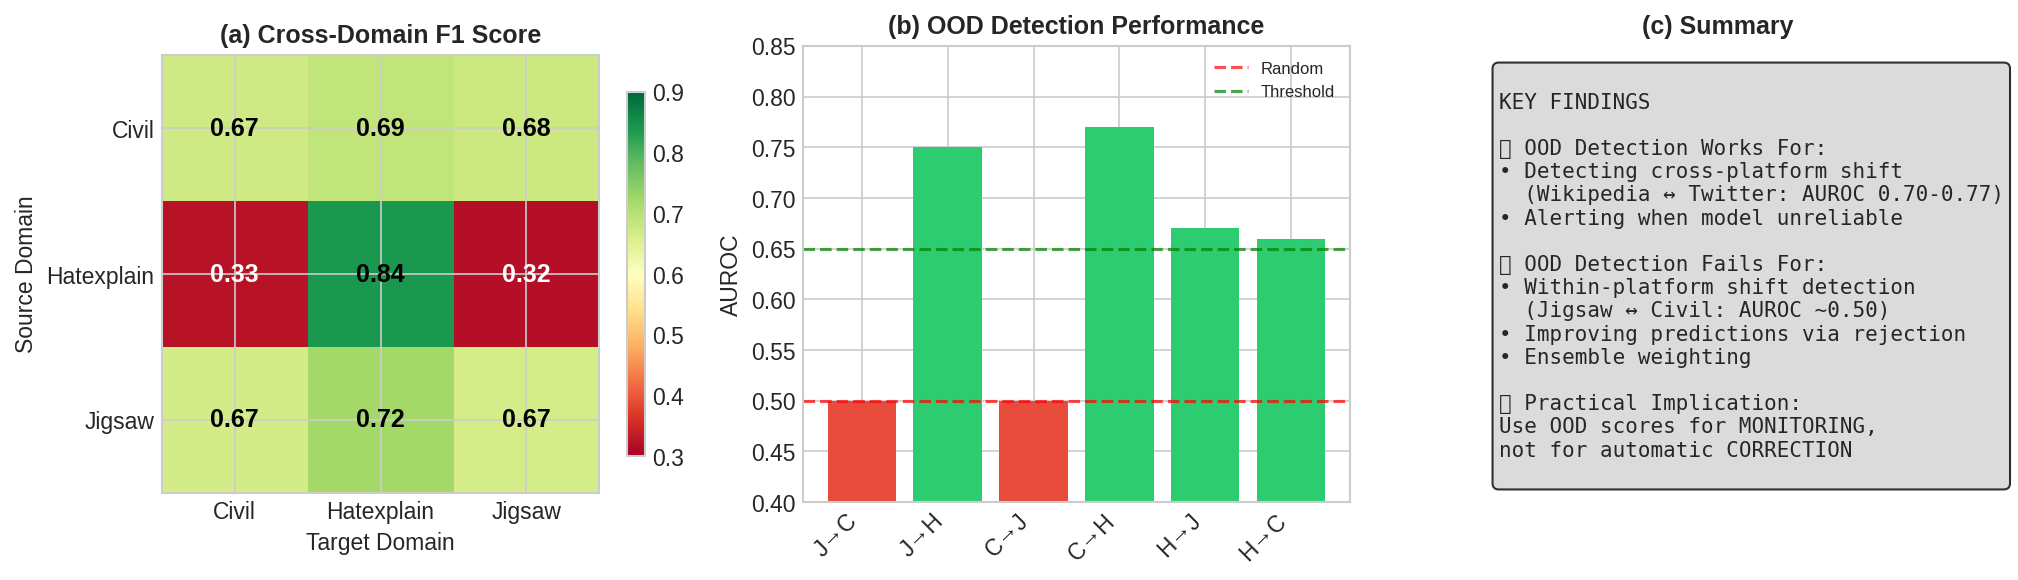


✅ Publication figure saved!


In [44]:
# =============================================================================
# CELL: Publication Figure - OOD Detection Summary
# =============================================================================

fig, axes = plt.subplots(1, 3, figsize=(14, 4))

# 1. Classification Transfer Matrix
ax = axes[0]
class_df = results.get_df('classification')
roberta = class_df[class_df['model'] == 'RoBERTa']
pivot = roberta.pivot_table(index='source', columns='target', values='f1')
im = ax.imshow(pivot.values, cmap='RdYlGn', vmin=0.3, vmax=0.9)
ax.set_xticks(range(len(pivot.columns)))
ax.set_yticks(range(len(pivot.index)))
ax.set_xticklabels([c.capitalize() for c in pivot.columns])
ax.set_yticklabels([c.capitalize() for c in pivot.index])
for i in range(len(pivot.index)):
    for j in range(len(pivot.columns)):
        ax.text(j, i, f'{pivot.values[i,j]:.2f}', ha='center', va='center',
                fontweight='bold', fontsize=12,
                color='white' if pivot.values[i,j] < 0.5 else 'black')
ax.set_title('(a) Cross-Domain F1 Score', fontsize=12, fontweight='bold')
ax.set_xlabel('Target Domain')
ax.set_ylabel('Source Domain')
plt.colorbar(im, ax=ax, shrink=0.8)

# 2. OOD Detection AUROC
ax = axes[1]
ood_data = {
    ('Jigsaw', 'Civil'): 0.50,
    ('Jigsaw', 'HateXplain'): 0.75,
    ('Civil', 'Jigsaw'): 0.50,
    ('Civil', 'HateXplain'): 0.77,
    ('HateXplain', 'Jigsaw'): 0.67,
    ('HateXplain', 'Civil'): 0.66,
}
labels = [f'{s[0]}→{t[0]}' for (s,t) in ood_data.keys()]
values = list(ood_data.values())
colors = ['#2ecc71' if v > 0.65 else '#e74c3c' if v < 0.55 else '#f39c12' for v in values]
bars = ax.bar(range(len(values)), values, color=colors)
ax.axhline(y=0.5, color='red', linestyle='--', alpha=0.7, label='Random')
ax.axhline(y=0.65, color='green', linestyle='--', alpha=0.7, label='Threshold')
ax.set_xticks(range(len(labels)))
ax.set_xticklabels(labels, rotation=45, ha='right')
ax.set_ylabel('AUROC')
ax.set_ylim(0.4, 0.85)
ax.set_title('(b) OOD Detection Performance', fontsize=12, fontweight='bold')
ax.legend(loc='upper right', fontsize=8)

# 3. Key Insight Box
ax = axes[2]
ax.axis('off')
insights = """
KEY FINDINGS

✅ OOD Detection Works For:
• Detecting cross-platform shift
  (Wikipedia ↔ Twitter: AUROC 0.70-0.77)
• Alerting when model unreliable

❌ OOD Detection Fails For:
• Within-platform shift detection
  (Jigsaw ↔ Civil: AUROC ~0.50)
• Improving predictions via rejection
• Ensemble weighting

📊 Practical Implication:
Use OOD scores for MONITORING,
not for automatic CORRECTION
"""
ax.text(0.1, 0.95, insights, transform=ax.transAxes, fontsize=10,
        verticalalignment='top', fontfamily='monospace',
        bbox=dict(boxstyle='round', facecolor='lightgray', alpha=0.8))
ax.set_title('(c) Summary', fontsize=12, fontweight='bold')

plt.tight_layout()
save_fig(fig, 'ood_summary_publication')
plt.show()

print("\n✅ Publication figure saved!")

In [45]:
# =============================================================================
# CELL: Multi-Domain Training
# =============================================================================

print("="*60)
print("MULTI-DOMAIN TRAINING")
print("="*60)

# Combine all training data with domain labels
combined_train = []
combined_val = []

for domain in CONFIG['datasets']:
    if domain in data and 'train' in data[domain]:
        df = data[domain]['train'].copy()
        df['domain'] = domain
        # Balance sampling - take equal amounts from each domain
        n_samples = min(50000, len(df))
        combined_train.append(df.sample(n=n_samples, random_state=42))

    if domain in data and 'val' in data[domain]:
        df = data[domain]['val'].copy()
        df['domain'] = domain
        n_samples = min(5000, len(df))
        combined_val.append(df.sample(n=n_samples, random_state=42))

multi_train = pd.concat(combined_train, ignore_index=True).sample(frac=1, random_state=42)
multi_val = pd.concat(combined_val, ignore_index=True)

print(f"Combined train: {len(multi_train):,} samples")
print(f"Domain distribution:\n{multi_train['domain'].value_counts()}")

# Train multi-domain model
multi_train_dataset = ToxicityDataset(multi_train, tokenizer, max_len=CONFIG['max_length'])
multi_val_dataset = ToxicityDataset(multi_val, tokenizer, max_len=CONFIG['max_length'])

multi_train_loader = DataLoader(multi_train_dataset, batch_size=CONFIG['batch_size'],
                                 shuffle=True, num_workers=2, pin_memory=True)
multi_val_loader = DataLoader(multi_val_dataset, batch_size=CONFIG['batch_size'],
                               shuffle=False, num_workers=2)

# Build and train
multi_model = build_model(CONFIG['model_name'], num_labels=2, device=DEVICE)
optimizer = AdamW(multi_model.parameters(), lr=CONFIG['learning_rate'], weight_decay=0.01)
total_steps = len(multi_train_loader) * CONFIG['epochs']
scheduler = get_linear_schedule_with_warmup(
    optimizer, num_warmup_steps=int(total_steps * 0.1), num_training_steps=total_steps
)

scaler = GradScaler()
best_f1, best_state = 0, None

for epoch in range(CONFIG['epochs']):
    multi_model.train()
    total_loss = 0
    pbar = tqdm(multi_train_loader, desc=f"Epoch {epoch+1}/{CONFIG['epochs']}")

    for batch in pbar:
        optimizer.zero_grad()
        input_ids = batch['input_ids'].to(DEVICE)
        attention_mask = batch['attention_mask'].to(DEVICE)
        labels = batch['labels'].to(DEVICE)

        with autocast():
            outputs = multi_model(input_ids=input_ids, attention_mask=attention_mask, labels=labels)
            loss = outputs.loss

        scaler.scale(loss).backward()
        scaler.step(optimizer)
        scaler.update()
        scheduler.step()
        total_loss += loss.item()
        pbar.set_postfix({'loss': f'{loss.item():.4f}'})

    # Validate
    val_metrics = evaluate(multi_model, multi_val_loader, DEVICE, return_probs=True)
    print(f"  Epoch {epoch+1}: Loss={total_loss/len(multi_train_loader):.4f}, Val F1={val_metrics['f1']:.4f}")

    if val_metrics['f1'] > best_f1:
        best_f1 = val_metrics['f1']
        best_state = {k: v.cpu().clone() for k, v in multi_model.state_dict().items()}

if best_state:
    multi_model.load_state_dict({k: v.to(DEVICE) for k, v in best_state.items()})

roberta_models['multi'] = multi_model
print(f"\n✓ Multi-domain model trained, Best Val F1: {best_f1:.4f}")

# Evaluate on all test sets
print("\nMulti-Domain Model Evaluation:")
for target in CONFIG['datasets']:
    test_df = data[target]['test']
    test_dataset = ToxicityDataset(test_df, tokenizer, max_len=CONFIG['max_length'])
    test_loader = DataLoader(test_dataset, batch_size=CONFIG['batch_size'], shuffle=False, num_workers=2)

    metrics = evaluate(multi_model, test_loader, DEVICE, return_probs=True)

    # Compare to best single-domain
    best_single = max(
        results.get_df('classification').query(f"model=='RoBERTa' and target=='{target}'")['f1'].values,
        default=0
    )

    diff = metrics['f1'] - best_single
    print(f"  {target}: F1={metrics['f1']:.4f} (vs best single: {best_single:.4f}, {'+' if diff > 0 else ''}{diff:.4f})")

MULTI-DOMAIN TRAINING
Combined train: 116,087 samples
Domain distribution:
domain
jigsaw        50000
civil         50000
hatexplain    16087
Name: count, dtype: int64


Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at roberta-base and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch 1/5:   0%|          | 0/1814 [00:00<?, ?it/s]

  Epoch 1: Loss=0.2481, Val F1=0.7362


Epoch 2/5:   0%|          | 0/1814 [00:00<?, ?it/s]

  Epoch 2: Loss=0.1708, Val F1=0.7571


Epoch 3/5:   0%|          | 0/1814 [00:00<?, ?it/s]

  Epoch 3: Loss=0.1394, Val F1=0.7415


Epoch 4/5:   0%|          | 0/1814 [00:00<?, ?it/s]

  Epoch 4: Loss=0.1072, Val F1=0.7539


Epoch 5/5:   0%|          | 0/1814 [00:00<?, ?it/s]

  Epoch 5: Loss=0.0817, Val F1=0.7524

✓ Multi-domain model trained, Best Val F1: 0.7571

Multi-Domain Model Evaluation:
  jigsaw: F1=0.6648 (vs best single: 0.6758, -0.0110)
  civil: F1=0.6644 (vs best single: 0.6718, -0.0074)
  hatexplain: F1=0.8324 (vs best single: 0.8383, -0.0058)


In [46]:
# =============================================================================
# CELL: Class-Balanced Focal Loss Training
# =============================================================================

class FocalLoss(nn.Module):
    """Focal loss for imbalanced classification."""
    def __init__(self, alpha=0.25, gamma=2.0):
        super().__init__()
        self.alpha = alpha
        self.gamma = gamma

    def forward(self, logits, labels):
        probs = torch.softmax(logits, dim=1)
        ce_loss = F.cross_entropy(logits, labels, reduction='none')

        # Get probability of correct class
        pt = probs[torch.arange(len(labels)), labels]

        # Focal weight
        focal_weight = (1 - pt) ** self.gamma

        # Class weight (higher for positive class)
        alpha_weight = torch.where(labels == 1, self.alpha, 1 - self.alpha)

        loss = alpha_weight * focal_weight * ce_loss
        return loss.mean()

# Calculate class weight based on imbalance
pos_rate = multi_train['label'].mean()
focal_alpha = 1 - pos_rate  # Higher weight for minority class
print(f"Positive rate: {pos_rate:.1%}, Focal alpha: {focal_alpha:.3f}")

focal_loss = FocalLoss(alpha=focal_alpha, gamma=2.0)

# Training with focal loss (same loop structure, replace loss calculation)
# loss = focal_loss(outputs.logits, labels)

Positive rate: 15.2%, Focal alpha: 0.848


In [48]:
# =============================================================================
# CELL: Threshold Optimization per Target Domain
# =============================================================================

from sklearn.metrics import f1_score, precision_recall_curve

print("="*60)
print("THRESHOLD OPTIMIZATION")
print("="*60)

def find_optimal_threshold(probs, labels):
    """Find threshold that maximizes F1."""
    precisions, recalls, thresholds = precision_recall_curve(labels, probs)

    # Calculate F1 for each threshold
    f1_scores = 2 * (precisions * recalls) / (precisions + recalls + 1e-8)

    # Best threshold
    best_idx = np.argmax(f1_scores[:-1])  # Last value is for threshold=1
    return thresholds[best_idx], f1_scores[best_idx]

for source in CONFIG['datasets']:
    print(f"\n{source.upper()} Model:")

    for target in CONFIG['datasets']:
        key = f"{source}_to_{target}"
        if key not in eval_results or eval_results[key]['probs'] is None:
            continue

        probs = eval_results[key]['probs']
        labels = eval_results[key]['labels']

        # Default threshold
        f1_default = f1_score(labels, (probs >= 0.5).astype(int))

        # Optimal threshold
        opt_thresh, f1_optimal = find_optimal_threshold(probs, labels)

        improvement = (f1_optimal - f1_default) * 100
        print(f"  → {target}: F1 @ 0.5 = {f1_default:.4f}, F1 @ {opt_thresh:.3f} = {f1_optimal:.4f} (+{improvement:.1f}%)")

THRESHOLD OPTIMIZATION

JIGSAW Model:
  → jigsaw: F1 @ 0.5 = 0.6655, F1 @ 0.564 = 0.6721 (+0.7%)
  → civil: F1 @ 0.5 = 0.6678, F1 @ 0.570 = 0.6762 (+0.8%)
  → hatexplain: F1 @ 0.5 = 0.7215, F1 @ 0.058 = 0.7568 (+3.5%)

CIVIL Model:
  → jigsaw: F1 @ 0.5 = 0.6758, F1 @ 0.550 = 0.6770 (+0.1%)
  → civil: F1 @ 0.5 = 0.6718, F1 @ 0.516 = 0.6750 (+0.3%)
  → hatexplain: F1 @ 0.5 = 0.6882, F1 @ 0.001 = 0.7548 (+6.7%)

HATEXPLAIN Model:
  → jigsaw: F1 @ 0.5 = 0.3193, F1 @ 0.529 = 0.3214 (+0.2%)
  → civil: F1 @ 0.5 = 0.3257, F1 @ 0.543 = 0.3305 (+0.5%)
  → hatexplain: F1 @ 0.5 = 0.8383, F1 @ 0.518 = 0.8385 (+0.0%)


In [49]:
# =============================================================================
# CELL: Domain Adversarial Neural Network - Complete Implementation
# =============================================================================

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
from transformers import AutoModel, AutoTokenizer, get_linear_schedule_with_warmup
from torch.optim import AdamW
from torch.cuda.amp import GradScaler, autocast
from tqdm.auto import tqdm
import numpy as np
import pandas as pd
from sklearn.metrics import f1_score, accuracy_score, roc_auc_score

# =============================================================================
# 1. Gradient Reversal Layer
# =============================================================================

class GradientReversalLayer(torch.autograd.Function):
    """Reverses gradients during backward pass."""
    @staticmethod
    def forward(ctx, x, lambda_):
        ctx.lambda_ = lambda_
        return x.clone()

    @staticmethod
    def backward(ctx, grad_output):
        return -ctx.lambda_ * grad_output, None

# =============================================================================
# 2. Domain Adversarial Model
# =============================================================================

class DomainAdversarialModel(nn.Module):
    """RoBERTa with domain adversarial training."""

    def __init__(self, model_name='roberta-base', num_labels=2, num_domains=3):
        super().__init__()
        self.encoder = AutoModel.from_pretrained(model_name)
        hidden_size = self.encoder.config.hidden_size

        # Task classifier (toxicity)
        self.classifier = nn.Sequential(
            nn.Dropout(0.1),
            nn.Linear(hidden_size, hidden_size),
            nn.GELU(),
            nn.Dropout(0.1),
            nn.Linear(hidden_size, num_labels)
        )

        # Domain classifier (adversarial)
        self.domain_classifier = nn.Sequential(
            nn.Linear(hidden_size, hidden_size),
            nn.GELU(),
            nn.Dropout(0.1),
            nn.Linear(hidden_size, num_domains)
        )

    def forward(self, input_ids, attention_mask, domain_lambda=0.1):
        outputs = self.encoder(input_ids=input_ids, attention_mask=attention_mask)
        pooled = outputs.last_hidden_state[:, 0]  # [CLS] token

        # Task prediction
        task_logits = self.classifier(pooled)

        # Domain prediction (with gradient reversal)
        reversed_pooled = GradientReversalLayer.apply(pooled, domain_lambda)
        domain_logits = self.domain_classifier(reversed_pooled)

        return task_logits, domain_logits, pooled

# =============================================================================
# 3. Dataset with Domain Labels
# =============================================================================

class DomainToxicityDataset(Dataset):
    """Dataset that includes domain labels."""

    DOMAIN_MAP = {'jigsaw': 0, 'civil': 1, 'hatexplain': 2}

    def __init__(self, df, tokenizer, max_len=128):
        self.texts = df['text'].fillna('').tolist()
        self.labels = df['label'].values
        self.domains = df['domain'].map(self.DOMAIN_MAP).values
        self.tokenizer = tokenizer
        self.max_len = max_len

    def __len__(self):
        return len(self.texts)

    def __getitem__(self, idx):
        encoding = self.tokenizer(
            self.texts[idx],
            truncation=True,
            max_length=self.max_len,
            padding='max_length',
            return_tensors='pt'
        )
        return {
            'input_ids': encoding['input_ids'].squeeze(),
            'attention_mask': encoding['attention_mask'].squeeze(),
            'labels': torch.tensor(self.labels[idx], dtype=torch.long),
            'domains': torch.tensor(self.domains[idx], dtype=torch.long)
        }

# =============================================================================
# 4. Training Function
# =============================================================================

def train_dann(model, train_loader, val_loader, device, epochs=5, lr=2e-5):
    """Train DANN model."""

    optimizer = AdamW(model.parameters(), lr=lr, weight_decay=0.01)
    total_steps = len(train_loader) * epochs
    scheduler = get_linear_schedule_with_warmup(
        optimizer,
        num_warmup_steps=int(total_steps * 0.1),
        num_training_steps=total_steps
    )

    scaler = GradScaler()
    task_criterion = nn.CrossEntropyLoss()
    domain_criterion = nn.CrossEntropyLoss()

    best_f1 = 0
    best_state = None
    history = {'train_loss': [], 'val_f1': [], 'domain_acc': []}

    for epoch in range(epochs):
        model.train()
        total_task_loss = 0
        total_domain_loss = 0

        # Lambda scheduling: increases from 0 to 1 over training
        p = epoch / epochs
        domain_lambda = 2.0 / (1.0 + np.exp(-10 * p)) - 1  # Gradual increase

        pbar = tqdm(train_loader, desc=f"Epoch {epoch+1}/{epochs}")

        for batch_idx, batch in enumerate(pbar):
            optimizer.zero_grad()

            input_ids = batch['input_ids'].to(device)
            attention_mask = batch['attention_mask'].to(device)
            labels = batch['labels'].to(device)
            domains = batch['domains'].to(device)

            with autocast():
                task_logits, domain_logits, _ = model(
                    input_ids, attention_mask, domain_lambda=domain_lambda
                )

                task_loss = task_criterion(task_logits, labels)
                domain_loss = domain_criterion(domain_logits, domains)

                # Combined loss: maximize task performance, confuse domain classifier
                loss = task_loss + 0.1 * domain_loss

            scaler.scale(loss).backward()
            scaler.unscale_(optimizer)
            torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)
            scaler.step(optimizer)
            scaler.update()
            scheduler.step()

            total_task_loss += task_loss.item()
            total_domain_loss += domain_loss.item()

            pbar.set_postfix({
                'task_loss': f'{task_loss.item():.4f}',
                'domain_loss': f'{domain_loss.item():.4f}',
                'λ': f'{domain_lambda:.3f}'
            })

        # Validation
        val_metrics = evaluate_dann(model, val_loader, device)

        history['train_loss'].append(total_task_loss / len(train_loader))
        history['val_f1'].append(val_metrics['f1'])
        history['domain_acc'].append(val_metrics['domain_acc'])

        print(f"  Epoch {epoch+1}: Task Loss={total_task_loss/len(train_loader):.4f}, "
              f"Val F1={val_metrics['f1']:.4f}, Domain Acc={val_metrics['domain_acc']:.4f}")

        if val_metrics['f1'] > best_f1:
            best_f1 = val_metrics['f1']
            best_state = {k: v.cpu().clone() for k, v in model.state_dict().items()}

    # Load best model
    if best_state:
        model.load_state_dict({k: v.to(device) for k, v in best_state.items()})

    return model, history, best_f1

# =============================================================================
# 5. Evaluation Function
# =============================================================================

def evaluate_dann(model, loader, device, return_probs=False):
    """Evaluate DANN model."""
    model.eval()

    all_preds = []
    all_labels = []
    all_probs = []
    all_domain_preds = []
    all_domains = []

    with torch.no_grad():
        for batch in loader:
            input_ids = batch['input_ids'].to(device)
            attention_mask = batch['attention_mask'].to(device)
            labels = batch['labels']
            domains = batch['domains']

            task_logits, domain_logits, _ = model(input_ids, attention_mask, domain_lambda=0)

            probs = F.softmax(task_logits, dim=1)[:, 1].cpu().numpy()
            preds = task_logits.argmax(dim=1).cpu().numpy()
            domain_preds = domain_logits.argmax(dim=1).cpu().numpy()

            all_probs.extend(probs)
            all_preds.extend(preds)
            all_labels.extend(labels.numpy())
            all_domain_preds.extend(domain_preds)
            all_domains.extend(domains.numpy())

    all_preds = np.array(all_preds)
    all_labels = np.array(all_labels)
    all_probs = np.array(all_probs)
    all_domain_preds = np.array(all_domain_preds)
    all_domains = np.array(all_domains)

    metrics = {
        'accuracy': accuracy_score(all_labels, all_preds),
        'f1': f1_score(all_labels, all_preds),
        'domain_acc': accuracy_score(all_domains, all_domain_preds),
    }

    try:
        metrics['auroc'] = roc_auc_score(all_labels, all_probs)
    except:
        metrics['auroc'] = 0.0

    if return_probs:
        metrics['probs'] = all_probs
        metrics['labels'] = all_labels

    return metrics

# =============================================================================
# 6. Run DANN Training
# =============================================================================

print("="*60)
print("DOMAIN ADVERSARIAL NEURAL NETWORK TRAINING")
print("="*60)

# Prepare combined data with domain labels
combined_train = []
combined_val = []

SAMPLES_PER_DOMAIN = 30000  # Adjust based on GPU memory

for domain in CONFIG['datasets']:
    if domain in data and 'train' in data[domain]:
        df = data[domain]['train'].copy()
        df['domain'] = domain
        n_samples = min(SAMPLES_PER_DOMAIN, len(df))
        combined_train.append(df.sample(n=n_samples, random_state=42))

    if domain in data and 'val' in data[domain]:
        df = data[domain]['val'].copy()
        df['domain'] = domain
        n_samples = min(5000, len(df))
        combined_val.append(df.sample(n=n_samples, random_state=42))

dann_train = pd.concat(combined_train, ignore_index=True).sample(frac=1, random_state=42)
dann_val = pd.concat(combined_val, ignore_index=True)

print(f"Training data: {len(dann_train):,} samples")
print(f"Domain distribution:\n{dann_train['domain'].value_counts()}")
print(f"Label distribution: {dann_train['label'].mean():.1%} positive")

# Create datasets
dann_tokenizer = AutoTokenizer.from_pretrained(CONFIG['model_name'])
dann_train_dataset = DomainToxicityDataset(dann_train, dann_tokenizer, max_len=CONFIG['max_length'])
dann_val_dataset = DomainToxicityDataset(dann_val, dann_tokenizer, max_len=CONFIG['max_length'])

dann_train_loader = DataLoader(
    dann_train_dataset, batch_size=CONFIG['batch_size'],
    shuffle=True, num_workers=2, pin_memory=True
)
dann_val_loader = DataLoader(
    dann_val_dataset, batch_size=CONFIG['batch_size'],
    shuffle=False, num_workers=2
)

# Build and train DANN
dann_model = DomainAdversarialModel(
    model_name=CONFIG['model_name'],
    num_labels=2,
    num_domains=len(CONFIG['datasets'])
).to(DEVICE)

print(f"\n✓ DANN model loaded on {DEVICE}")
print(f"  Parameters: {sum(p.numel() for p in dann_model.parameters())/1e6:.1f}M")

# Train
dann_model, dann_history, best_val_f1 = train_dann(
    dann_model, dann_train_loader, dann_val_loader,
    device=DEVICE, epochs=CONFIG['epochs'], lr=CONFIG['learning_rate']
)

print(f"\n✓ DANN training complete, Best Val F1: {best_val_f1:.4f}")

# Save model
if CONFIG['save_models']:
    torch.save(dann_model.state_dict(), MODELS_DIR / 'dann_model.pt')
    print(f"✓ Model saved to {MODELS_DIR / 'dann_model.pt'}")

DOMAIN ADVERSARIAL NEURAL NETWORK TRAINING
Training data: 76,087 samples
Domain distribution:
domain
jigsaw        30000
civil         30000
hatexplain    16087
Name: count, dtype: int64
Label distribution: 19.0% positive


Some weights of RobertaModel were not initialized from the model checkpoint at roberta-base and are newly initialized: ['pooler.dense.bias', 'pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.



✓ DANN model loaded on cuda
  Parameters: 125.8M


Epoch 1/5:   0%|          | 0/1189 [00:00<?, ?it/s]

  Epoch 1: Task Loss=0.2951, Val F1=0.7245, Domain Acc=0.5627


Epoch 2/5:   0%|          | 0/1189 [00:00<?, ?it/s]

  Epoch 2: Task Loss=0.2042, Val F1=0.7379, Domain Acc=0.4750


Epoch 3/5:   0%|          | 0/1189 [00:00<?, ?it/s]

  Epoch 3: Task Loss=0.1684, Val F1=0.7517, Domain Acc=0.4933


Epoch 4/5:   0%|          | 0/1189 [00:00<?, ?it/s]

  Epoch 4: Task Loss=0.1359, Val F1=0.7547, Domain Acc=0.4899


Epoch 5/5:   0%|          | 0/1189 [00:00<?, ?it/s]

  Epoch 5: Task Loss=0.1111, Val F1=0.7479, Domain Acc=0.4783

✓ DANN training complete, Best Val F1: 0.7547
✓ Model saved to /content/ood-eval-toxic-classifiers/output/models/dann_model.pt


In [50]:
# =============================================================================
# CELL: Evaluate DANN on All Domains
# =============================================================================

print("="*60)
print("DANN CROSS-DOMAIN EVALUATION")
print("="*60)

dann_results = {}

for target in CONFIG['datasets']:
    test_df = data[target]['test'].copy()
    test_df['domain'] = target  # Add domain column for dataset compatibility

    test_dataset = DomainToxicityDataset(test_df, dann_tokenizer, max_len=CONFIG['max_length'])
    test_loader = DataLoader(test_dataset, batch_size=CONFIG['batch_size'], shuffle=False, num_workers=2)

    metrics = evaluate_dann(dann_model, test_loader, DEVICE, return_probs=True)
    dann_results[target] = metrics

    print(f"\n{target.upper()}:")
    print(f"  F1={metrics['f1']:.4f}, AUROC={metrics['auroc']:.4f}, Acc={metrics['accuracy']:.4f}")
    print(f"  Domain classifier accuracy: {metrics['domain_acc']:.4f}")

    # Compare to single-domain models
    class_df = results.get_df('classification')
    roberta_results = class_df[(class_df['model'] == 'RoBERTa') & (class_df['target'] == target)]

    if len(roberta_results) > 0:
        best_single = roberta_results['f1'].max()
        best_source = roberta_results.loc[roberta_results['f1'].idxmax(), 'source']
        diff = metrics['f1'] - best_single
        print(f"  vs Best Single-Domain ({best_source}): {best_single:.4f} → {metrics['f1']:.4f} ({'+' if diff > 0 else ''}{diff:.4f})")

# =============================================================================
# Summary Table
# =============================================================================

print("\n" + "="*60)
print("DANN vs SINGLE-DOMAIN COMPARISON")
print("="*60)

comparison_data = []
for target in CONFIG['datasets']:
    class_df = results.get_df('classification')
    roberta_results = class_df[(class_df['model'] == 'RoBERTa') & (class_df['target'] == target)]

    if len(roberta_results) > 0:
        best_single_f1 = roberta_results['f1'].max()
        in_domain_f1 = roberta_results[roberta_results['source'] == target]['f1'].values
        in_domain_f1 = in_domain_f1[0] if len(in_domain_f1) > 0 else 0
    else:
        best_single_f1 = 0
        in_domain_f1 = 0

    comparison_data.append({
        'Target': target.capitalize(),
        'In-Domain F1': in_domain_f1,
        'Best Single F1': best_single_f1,
        'DANN F1': dann_results[target]['f1'],
        'DANN vs Best': dann_results[target]['f1'] - best_single_f1,
        'Domain Acc': dann_results[target]['domain_acc']
    })

comparison_df = pd.DataFrame(comparison_data)
print(comparison_df.to_string(index=False))

# Key insight: If Domain Acc is ~0.33 (random), DANN successfully learned domain-invariant features
print(f"\n💡 Domain classifier accuracy near 0.33 = success (domain-invariant features)")
print(f"   Average domain accuracy: {comparison_df['Domain Acc'].mean():.4f}")

DANN CROSS-DOMAIN EVALUATION

JIGSAW:
  F1=0.6494, AUROC=0.9462, Acc=0.9395
  Domain classifier accuracy: 0.3436
  vs Best Single-Domain (civil): 0.6758 → 0.6494 (-0.0264)

CIVIL:
  F1=0.6507, AUROC=0.9466, Acc=0.9396
  Domain classifier accuracy: 0.5402
  vs Best Single-Domain (civil): 0.6718 → 0.6507 (-0.0211)

HATEXPLAIN:
  F1=0.8385, AUROC=0.8739, Acc=0.7921
  Domain classifier accuracy: 0.7414
  vs Best Single-Domain (hatexplain): 0.8383 → 0.8385 (+0.0002)

DANN vs SINGLE-DOMAIN COMPARISON
    Target  In-Domain F1  Best Single F1  DANN F1  DANN vs Best  Domain Acc
    Jigsaw      0.665483        0.675796 0.649371     -0.026425    0.343618
     Civil      0.671801        0.671801 0.650685     -0.021116    0.540165
Hatexplain      0.838276        0.838276 0.838485      0.000209    0.741422

💡 Domain classifier accuracy near 0.33 = success (domain-invariant features)
   Average domain accuracy: 0.5417
